# Setup

In [456]:
import pandas as pd
from urllib.request import Request, urlopen
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

pd.set_option('display.max_rows', None)

# define function to convert from MM:SS to seconds
def sec_convert(str):
    if str: # need this to not try to split on None values for duration (goal events)
        mins, secs = str.split(':')
        return int(mins)*60 + int(secs)

# Build working scrape and calculation for single game

In [373]:
# load player data for same game as shift data above and convert it to a dictionary
req = Request('https://statsapi.web.nhl.com/api/v1/game/2020020001/feed/live', 
              headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
page_json = json.loads(webpage)

# get dictionary of "gameData" section which contains game info
game_data = page_json['gameData']

# get abbreviations of home and away teams in game
home_team = game_data['teams']['home']['abbreviation']
away_team = game_data['teams']['away']['abbreviation']

# get dictionary of "boxscore" section which contains all players and shift times at different strengths
boxscore = page_json['liveData']['boxscore']

# get dictionary of "players" section
home_players = boxscore['teams']['home']['players']
away_players = boxscore['teams']['away']['players']

# get list of player IDs for each team
home_IDs = list(home_players.keys())
away_IDs = list(away_players.keys())

In [374]:
# create list to store total shift time for each player in the game
home_forward_id = []
home_forward_name = []
home_EV_shift_time = []

away_forward_id = []
away_forward_name = []
away_EV_shift_time = []

# iterate through IDs of all forwards on away team and record their even strength ice time
for ID in home_IDs:
    if home_players[ID]['position']['type'] == 'Forward':
        home_forward_id.append(home_players[ID]['person']['id'])
        home_forward_name.append(home_players[ID]['person']['fullName'])
        home_EV_shift_time.append(home_players[ID]['stats']['skaterStats']['evenTimeOnIce'])
        
for ID in away_IDs:
    if away_players[ID]['position']['type'] == 'Forward':
        away_forward_id.append(away_players[ID]['person']['id'])
        away_forward_name.append(away_players[ID]['person']['fullName'])
        away_EV_shift_time.append(away_players[ID]['stats']['skaterStats']['evenTimeOnIce'])

In [375]:
# create dataframes from lists
home_df = pd.DataFrame({
    'player id': home_forward_id,
    'player name': home_forward_name,
    '5v5 shift time': home_EV_shift_time
})

away_df = pd.DataFrame({
    'player id': away_forward_id,
    'player name': away_forward_name,
    '5v5 shift time': away_EV_shift_time
})

In [376]:
# define function to convert from MM:SS to seconds
def sec_convert(str):
    if str: # need this to not try to split on None values for duration (goal events)
        mins, secs = str.split(':')
        return int(mins)*60 + int(secs)

# convert shift time column from MM:SS to seconds
home_df['5v5 shift time (sec)'] = home_df['5v5 shift time'].apply(sec_convert)
away_df['5v5 shift time (sec)'] = away_df['5v5 shift time'].apply(sec_convert)

In [377]:
# add column with fraction of total 5v5 shift time for each player
home_total_5v5_time = sum(home_df['5v5 shift time (sec)'])
home_df['fraction of total 5v5 time'] = home_df['5v5 shift time (sec)']/home_total_5v5_time

away_total_5v5_time = sum(away_df['5v5 shift time (sec)'])
away_df['fraction of total 5v5 time'] = away_df['5v5 shift time (sec)']/away_total_5v5_time

In [378]:
# sort by fraction of total 5v5 time descending
home_df = home_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
away_df = away_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)

In [379]:
# say that 3 forwards with most ice time are top line, sum their fraction vs. rest of forwards
home_topline_fraction = sum(home_df['fraction of total 5v5 time'][:3])
home_remainder_fraction = sum(home_df['fraction of total 5v5 time'][3:])

away_topline_fraction = sum(away_df['fraction of total 5v5 time'][:3])
away_remainder_fraction = sum(away_df['fraction of total 5v5 time'][3:])

In [380]:
# create lists to store results across all games
home_team_list = []
home_topline_fraction_list = []
home_remainder_fraction_list = []

away_team_list = []
away_topline_fraction_list = []
away_remainder_fraction_list = []

In [381]:
# append results from this game to lists
home_team_list.append(home_team)
home_topline_fraction_list.append(home_topline_fraction)
home_remainder_fraction_list.append(home_remainder_fraction)

away_team_list.append(away_team)
away_topline_fraction_list.append(away_topline_fraction)
away_remainder_fraction_list.append(away_remainder_fraction)

In [382]:
# convert lists to dataframes
results_df = pd.DataFrame({
    'home team': home_team_list,
    'home top line fraction': home_topline_fraction_list,
    'home 2-4 lines fraction': home_remainder_fraction_list,
    'away team': away_team_list,
    'away top line fraction': away_topline_fraction_list,
    'away 2-4 lines fraction': away_remainder_fraction_list
})

In [383]:
results_df

,home team,home top line fraction,home 2-4 lines fraction,away team,away top line fraction,away 2-4 lines fraction
0,PHI,0.278398,0.721602,PIT,0.297306,0.702694


# Automated scraping and calculation

## 2020-2021 Regular Season

In [457]:
# create lists to store results across all games
home_team_list = []
home_topline_fraction_list = []
home_remainder_fraction_list = []

away_team_list = []
away_topline_fraction_list = []
away_remainder_fraction_list = []

# For regular season and preseason games, this ranges from 0001 to the number of games played.
# 2020-2021 reg. season only had 56 games per team and only 868 games total
root = '202002'
for game in range(1, 869):
    if game<10:
        code = root+'000'+str(game)
    elif game<100:
        code = root+'00'+str(game)
    elif game<1000:
        code = root+'0'+str(game)
    else:
        code = root+str(game)
        
            
    url = 'https://statsapi.web.nhl.com/api/v1/game/'+str(code)+'/feed/live'
        
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page_json = json.loads(webpage)
        
    # get dictionary of "gameData" section which contains game info
    game_data = page_json['gameData']

    # get abbreviations of home and away teams in game
    home_team = game_data['teams']['home']['abbreviation']
    away_team = game_data['teams']['away']['abbreviation']

    # get dictionary of "boxscore" section which contains all players and shift times at different strengths
    boxscore = page_json['liveData']['boxscore']

    # get dictionary of "players" section
    home_players = boxscore['teams']['home']['players']
    away_players = boxscore['teams']['away']['players']

    # get list of player IDs for each team
    home_IDs = list(home_players.keys())
    away_IDs = list(away_players.keys())
        
    # create list to store total shift time for each player in the game
    home_forward_id = []
    home_forward_name = []
    home_EV_shift_time = []

    away_forward_id = []
    away_forward_name = []
    away_EV_shift_time = []

    # iterate through IDs of all forwards on away team and record their even strength ice time
    for ID in home_IDs:
        if home_players[ID]['position']['type'] == 'Forward':
            home_forward_id.append(home_players[ID]['person']['id'])
            home_forward_name.append(home_players[ID]['person']['fullName'])
            home_EV_shift_time.append(home_players[ID]['stats']['skaterStats']['evenTimeOnIce'])

    for ID in away_IDs:
        if away_players[ID]['position']['type'] == 'Forward':
            away_forward_id.append(away_players[ID]['person']['id'])
            away_forward_name.append(away_players[ID]['person']['fullName'])
            away_EV_shift_time.append(away_players[ID]['stats']['skaterStats']['evenTimeOnIce'])
                
    # create dataframes from lists
    home_df = pd.DataFrame({
        'player id': home_forward_id,
        'player name': home_forward_name,
        '5v5 shift time': home_EV_shift_time
    })

    away_df = pd.DataFrame({
        'player id': away_forward_id,
        'player name': away_forward_name,
        '5v5 shift time': away_EV_shift_time
    })
        
    # convert shift time column from MM:SS to seconds
    home_df['5v5 shift time (sec)'] = home_df['5v5 shift time'].apply(sec_convert)
    away_df['5v5 shift time (sec)'] = away_df['5v5 shift time'].apply(sec_convert)
        
    # add column with fraction of total 5v5 shift time for each player
    home_total_5v5_time = sum(home_df['5v5 shift time (sec)'])
    home_df['fraction of total 5v5 time'] = home_df['5v5 shift time (sec)']/home_total_5v5_time

    away_total_5v5_time = sum(away_df['5v5 shift time (sec)'])
    away_df['fraction of total 5v5 time'] = away_df['5v5 shift time (sec)']/away_total_5v5_time
        
    # sort by fraction of total 5v5 time descending
    home_df = home_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
    away_df = away_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
        
    # say that 3 forwards with most ice time are top line, sum their fraction vs. rest of forwards
    home_topline_fraction = sum(home_df['fraction of total 5v5 time'][:3])
    home_remainder_fraction = sum(home_df['fraction of total 5v5 time'][3:])

    away_topline_fraction = sum(away_df['fraction of total 5v5 time'][:3])
    away_remainder_fraction = sum(away_df['fraction of total 5v5 time'][3:])
        
    # append results from this game to lists
    home_team_list.append(home_team)
    home_topline_fraction_list.append(home_topline_fraction)
    home_remainder_fraction_list.append(home_remainder_fraction)

    away_team_list.append(away_team)
    away_topline_fraction_list.append(away_topline_fraction)
    away_remainder_fraction_list.append(away_remainder_fraction)
    
# convert lists to dataframes
home_results_df = pd.DataFrame({
    'team': home_team_list,
    'top line fraction': home_topline_fraction_list,
    '2-4 lines fraction': home_remainder_fraction_list
})

away_results_df = pd.DataFrame({
    'team': away_team_list,
    'top line fraction': away_topline_fraction_list,
    '2-4 lines fraction': away_remainder_fraction_list
})

## 2020-2021 Playoffs

In [292]:
"""
For playoff games, the 2nd digit of the specific number gives the round of the playoffs, 
the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).
ex. Round 1, matchup 1, game 1 is 0111
8 matchups in 1st round: 011x, 012x, 013x, 014x, 015x, 016x, 017x, 018x where x depends on series length
4 matchups in 2nd round: 021x, 022x, 023x, 024x
2 matchups in 3rd round: 031x, 032x
1 matchup in 4th round: 041x

Series lengths:
1st round - 6, 5, 6, 6, 4, 7, 7, 4
2nd round - 6, 5, 6, 4
3rd round - 6, 7
4th round - 5
"""

# create lists to store results across all games
home_team_list_po = []
home_topline_fraction_list_po = []
home_remainder_fraction_list_po = []

away_team_list_po = []
away_topline_fraction_list_po = []
away_remainder_fraction_list_po = []

root = 202003
game_codes = ['0111', '0112', '0113', '0114', '0115', '0116', '0121', '0122', '0123', '0124', '0125',
              '0131', '0132', '0133', '0134', '0135', '0136', '0141', '0142', '0143', '0144', '0145',
              '0146', '0151', '0152', '0153', '0154', '0161', '0162', '0163', '0164', '0165', '0166',
              '0167', '0171', '0172', '0173', '0174', '0175', '0176', '0177', '0181', '0182', '0183', 
              '0184', '0211', '0212', '0213', '0214', '0215', '0216', '0221', '0222', '0223', '0224', 
              '0225', '0231', '0232', '0233', '0234', '0235', '0236', '0241', '0242', '0243', '0244', 
              '0311', '0312', '0313', '0314', '0315', '0316', '0321', '0322', '0323', '0324', '0325',
              '0326', '0327', '0411', '0412', '0413', '0414', '0415']
for game_code in game_codes:
            
    url = 'https://statsapi.web.nhl.com/api/v1/game/'+str(root)+game_code+'/feed/live'
    
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page_json = json.loads(webpage)
        
    # get dictionary of "gameData" section which contains game info
    game_data = page_json['gameData']

    # get abbreviations of home and away teams in game
    home_team = game_data['teams']['home']['abbreviation']
    away_team = game_data['teams']['away']['abbreviation']

    # get dictionary of "boxscore" section which contains all players and shift times at different strengths
    boxscore = page_json['liveData']['boxscore']

    # get dictionary of "players" section
    home_players = boxscore['teams']['home']['players']
    away_players = boxscore['teams']['away']['players']

    # get list of player IDs for each team
    home_IDs = list(home_players.keys())
    away_IDs = list(away_players.keys())
        
    # create list to store total shift time for each player in the game
    home_forward_id = []
    home_forward_name = []
    home_EV_shift_time = []

    away_forward_id = []
    away_forward_name = []
    away_EV_shift_time = []

    # iterate through IDs of all forwards on away team and record their even strength ice time
    for ID in home_IDs:
        if home_players[ID]['position']['type'] == 'Forward':
            home_forward_id.append(home_players[ID]['person']['id'])
            home_forward_name.append(home_players[ID]['person']['fullName'])
            home_EV_shift_time.append(home_players[ID]['stats']['skaterStats']['evenTimeOnIce'])

    for ID in away_IDs:
        if away_players[ID]['position']['type'] == 'Forward':
            away_forward_id.append(away_players[ID]['person']['id'])
            away_forward_name.append(away_players[ID]['person']['fullName'])
            away_EV_shift_time.append(away_players[ID]['stats']['skaterStats']['evenTimeOnIce'])
                
    # create dataframes from lists
    home_df = pd.DataFrame({
        'player id': home_forward_id,
        'player name': home_forward_name,
        '5v5 shift time': home_EV_shift_time
    })

    away_df = pd.DataFrame({
        'player id': away_forward_id,
        'player name': away_forward_name,
        '5v5 shift time': away_EV_shift_time
    })
        
    # convert shift time column from MM:SS to seconds
    home_df['5v5 shift time (sec)'] = home_df['5v5 shift time'].apply(sec_convert)
    away_df['5v5 shift time (sec)'] = away_df['5v5 shift time'].apply(sec_convert)
        
    # add column with fraction of total 5v5 shift time for each player
    home_total_5v5_time = sum(home_df['5v5 shift time (sec)'])
    home_df['fraction of total 5v5 time'] = home_df['5v5 shift time (sec)']/home_total_5v5_time

    away_total_5v5_time = sum(away_df['5v5 shift time (sec)'])
    away_df['fraction of total 5v5 time'] = away_df['5v5 shift time (sec)']/away_total_5v5_time
        
    # sort by fraction of total 5v5 time descending
    home_df = home_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
    away_df = away_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
        
    # say that 3 forwards with most ice time are top line, sum their fraction vs. rest of forwards
    home_topline_fraction = sum(home_df['fraction of total 5v5 time'][:3])
    home_remainder_fraction = sum(home_df['fraction of total 5v5 time'][3:])

    away_topline_fraction = sum(away_df['fraction of total 5v5 time'][:3])
    away_remainder_fraction = sum(away_df['fraction of total 5v5 time'][3:])
        
    # append results from this game to lists
    home_team_list_po.append(home_team)
    home_topline_fraction_list_po.append(home_topline_fraction)
    home_remainder_fraction_list_po.append(home_remainder_fraction)

    away_team_list_po.append(away_team)
    away_topline_fraction_list_po.append(away_topline_fraction)
    away_remainder_fraction_list_po.append(away_remainder_fraction)
    
# convert lists to dataframes
home_results_df_po = pd.DataFrame({
    'team': home_team_list_po,
    'top line fraction': home_topline_fraction_list_po,
    '2-4 lines fraction': home_remainder_fraction_list_po
})

away_results_df_po = pd.DataFrame({
    'team': away_team_list_po,
    'top line fraction': away_topline_fraction_list_po,
    '2-4 lines fraction': away_remainder_fraction_list_po
})

## 2021-2022 Regular Season

In [497]:
# create lists to store results across all games
home_team_list = []
home_topline_fraction_list = []
home_remainder_fraction_list = []

away_team_list = []
away_topline_fraction_list = []
away_remainder_fraction_list = []

# For regular season and preseason games, this ranges from 0001 to the number of games played.
# at the time of me completing this task there were 382 games played so far
root = '202102'
for game in range(1, 383):
    if game<10:
        code = root+'000'+str(game)
    elif game<100:
        code = root+'00'+str(game)
    else:
        code = root+'0'+str(game)
        
            
    url = 'https://statsapi.web.nhl.com/api/v1/game/'+str(code)+'/feed/live'
        
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page_json = json.loads(webpage)
        
    # get dictionary of "gameData" section which contains game info
    game_data = page_json['gameData']

    # get abbreviations of home and away teams in game
    home_team = game_data['teams']['home']['abbreviation']
    away_team = game_data['teams']['away']['abbreviation']

    # get dictionary of "boxscore" section which contains all players and shift times at different strengths
    boxscore = page_json['liveData']['boxscore']

    # get dictionary of "players" section
    home_players = boxscore['teams']['home']['players']
    away_players = boxscore['teams']['away']['players']

    # get list of player IDs for each team
    home_IDs = list(home_players.keys())
    away_IDs = list(away_players.keys())
        
    # create list to store total shift time for each player in the game
    home_forward_id = []
    home_forward_name = []
    home_EV_shift_time = []

    away_forward_id = []
    away_forward_name = []
    away_EV_shift_time = []

    # iterate through IDs of all forwards on away team and record their even strength ice time
    for ID in home_IDs:
        if home_players[ID]['position']['type'] == 'Forward':
            home_forward_id.append(home_players[ID]['person']['id'])
            home_forward_name.append(home_players[ID]['person']['fullName'])
            home_EV_shift_time.append(home_players[ID]['stats']['skaterStats']['evenTimeOnIce'])

    for ID in away_IDs:
        if away_players[ID]['position']['type'] == 'Forward':
            away_forward_id.append(away_players[ID]['person']['id'])
            away_forward_name.append(away_players[ID]['person']['fullName'])
            away_EV_shift_time.append(away_players[ID]['stats']['skaterStats']['evenTimeOnIce'])
                
    # create dataframes from lists
    home_df = pd.DataFrame({
        'player id': home_forward_id,
        'player name': home_forward_name,
        '5v5 shift time': home_EV_shift_time
    })

    away_df = pd.DataFrame({
        'player id': away_forward_id,
        'player name': away_forward_name,
        '5v5 shift time': away_EV_shift_time
    })
        
    # convert shift time column from MM:SS to seconds
    home_df['5v5 shift time (sec)'] = home_df['5v5 shift time'].apply(sec_convert)
    away_df['5v5 shift time (sec)'] = away_df['5v5 shift time'].apply(sec_convert)
        
    # add column with fraction of total 5v5 shift time for each player
    home_total_5v5_time = sum(home_df['5v5 shift time (sec)'])
    home_df['fraction of total 5v5 time'] = home_df['5v5 shift time (sec)']/home_total_5v5_time

    away_total_5v5_time = sum(away_df['5v5 shift time (sec)'])
    away_df['fraction of total 5v5 time'] = away_df['5v5 shift time (sec)']/away_total_5v5_time
        
    # sort by fraction of total 5v5 time descending
    home_df = home_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
    away_df = away_df.sort_values(by=['fraction of total 5v5 time'], ascending=False)
        
    # say that 3 forwards with most ice time are top line, sum their fraction vs. rest of forwards
    home_topline_fraction = sum(home_df['fraction of total 5v5 time'][:3])
    home_remainder_fraction = sum(home_df['fraction of total 5v5 time'][3:])

    away_topline_fraction = sum(away_df['fraction of total 5v5 time'][:3])
    away_remainder_fraction = sum(away_df['fraction of total 5v5 time'][3:])
        
    # append results from this game to lists
    home_team_list.append(home_team)
    home_topline_fraction_list.append(home_topline_fraction)
    home_remainder_fraction_list.append(home_remainder_fraction)

    away_team_list.append(away_team)
    away_topline_fraction_list.append(away_topline_fraction)
    away_remainder_fraction_list.append(away_remainder_fraction)
    
# convert lists to dataframes
home_results_df = pd.DataFrame({
    'team': home_team_list,
    'top line fraction': home_topline_fraction_list,
    '2-4 lines fraction': home_remainder_fraction_list
})

away_results_df = pd.DataFrame({
    'team': away_team_list,
    'top line fraction': away_topline_fraction_list,
    '2-4 lines fraction': away_remainder_fraction_list
})

# Aggregate by team, graph, analyze results

## 2020-2021

In [458]:
# create lists to store data for all teams for easy comparison
team_abbrev_list = []
reg_season_avg_list = []
playoff_avg_list = []
combined_avg_list = []

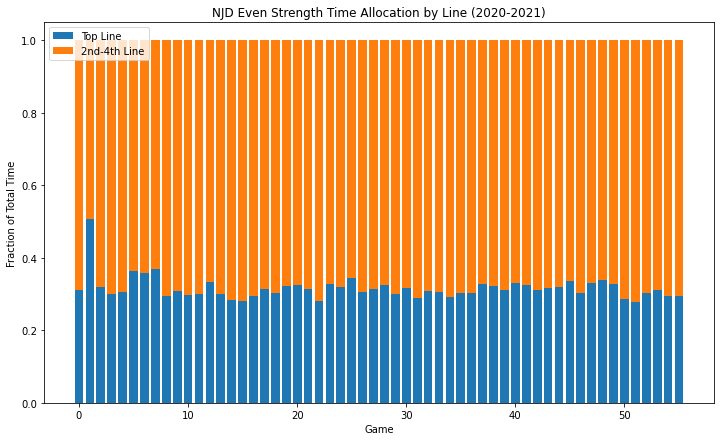

Average Fraction of Even Strength Time by Top Line (regular season):  0.31620975503245474


In [459]:
# New Jersey Devils
NJD_home_df = home_results_df[home_results_df['team'] == 'NJD']
NJD_away_df = away_results_df[away_results_df['team'] == 'NJD']
NJD_df = pd.concat([NJD_home_df, NJD_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = NJD_df['top line fraction']
remainder_fraction = NJD_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('NJD Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('NJD')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

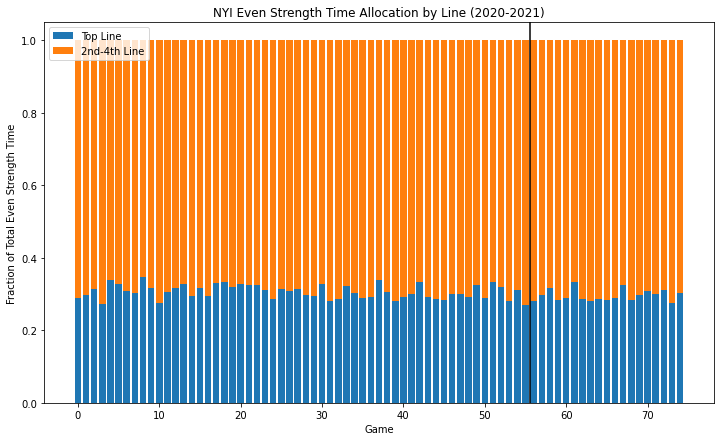

Average Fraction of Even Strength Time by Top Line (regular season):  0.30674070348170873
Average Fraction of Even Strength Time by Top Line (playoffs):  0.2963579211946501
Average Fraction of Even Strength Time by Top Line (combined):  0.30411039863565387


In [460]:
# New York Islanders - playoff team
NYI_home_df = home_results_df[home_results_df['team'] == 'NYI']
NYI_away_df = away_results_df[away_results_df['team'] == 'NYI']
NYI_home_df_po = home_results_df_po[home_results_df_po['team'] == 'NYI']
NYI_away_df_po = away_results_df_po[away_results_df_po['team'] == 'NYI']
NYI_df_reg = pd.concat([NYI_home_df, NYI_away_df], axis=0).sort_index()
NYI_df_po = pd.concat([NYI_home_df_po, NYI_away_df_po], axis=0).sort_index()
NYI_df = pd.concat([NYI_df_reg, NYI_df_po], axis=0)
num_games = len(NYI_df)
labels = [i for i in range(num_games)]
topline_fraction = NYI_df['top line fraction']
remainder_fraction = NYI_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('NYI Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('NYI')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

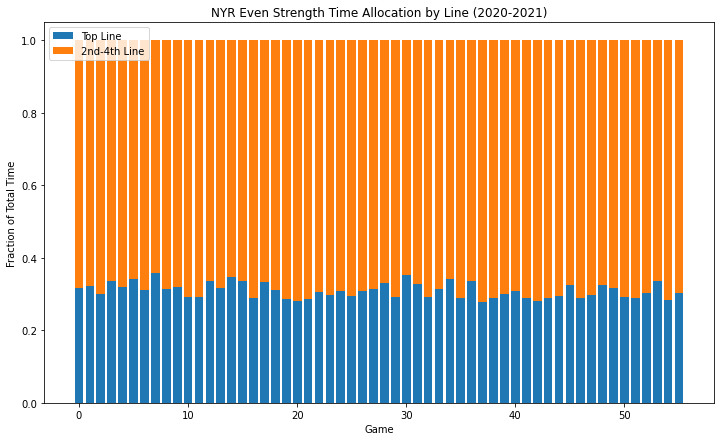

Average Fraction of Even Strength Time by Top Line (regular season):  0.30967354670891817


In [461]:
# New York Rangers
NYR_home_df = home_results_df[home_results_df['team'] == 'NYR']
NYR_away_df = away_results_df[away_results_df['team'] == 'NYR']
NYR_df = pd.concat([NYR_home_df, NYR_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = NYR_df['top line fraction']
remainder_fraction = NYR_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('NYR Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('NYR')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

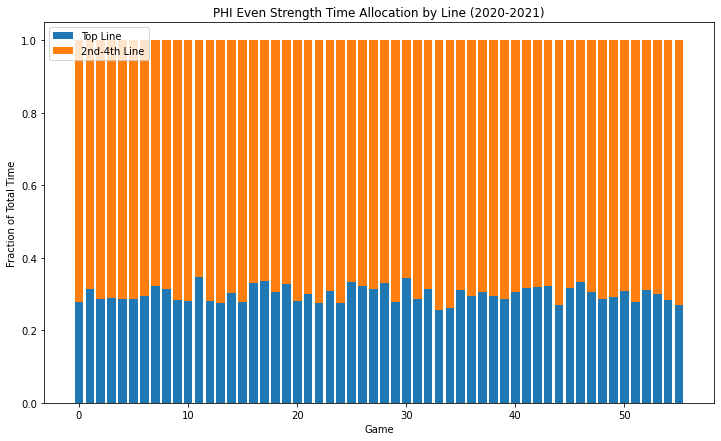

Average Fraction of Even Strength Time by Top Line (regular season):  0.30024715636116656


In [462]:
# Philadelphia Flyers
PHI_home_df = home_results_df[home_results_df['team'] == 'PHI']
PHI_away_df = away_results_df[away_results_df['team'] == 'PHI']
PHI_df = pd.concat([PHI_home_df, PHI_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = PHI_df['top line fraction']
remainder_fraction = PHI_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('PHI Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('PHI')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

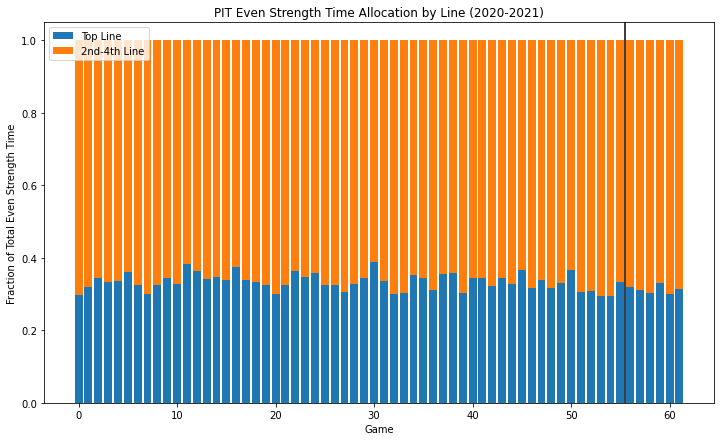

Average Fraction of Even Strength Time by Top Line (regular season):  0.3338601045288457
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3128087871737269
Average Fraction of Even Strength Time by Top Line (combined):  0.33182288026867307


In [463]:
# Pittsburgh Penguins - playoff team
PIT_home_df = home_results_df[home_results_df['team'] == 'PIT']
PIT_away_df = away_results_df[away_results_df['team'] == 'PIT']
PIT_home_df_po = home_results_df_po[home_results_df_po['team'] == 'PIT']
PIT_away_df_po = away_results_df_po[away_results_df_po['team'] == 'PIT']
PIT_df_reg = pd.concat([PIT_home_df, PIT_away_df], axis=0).sort_index()
PIT_df_po = pd.concat([PIT_home_df_po, PIT_away_df_po], axis=0).sort_index()
PIT_df = pd.concat([PIT_df_reg, PIT_df_po], axis=0)
num_games = len(PIT_df)
labels = [i for i in range(num_games)]
topline_fraction = PIT_df['top line fraction']
remainder_fraction = PIT_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('PIT Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('PIT')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

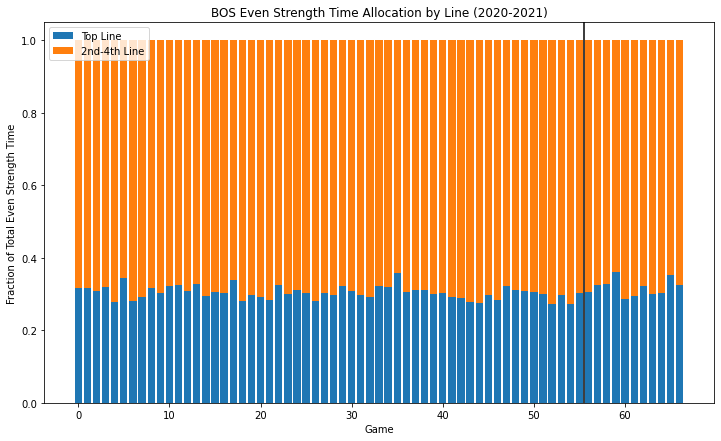

Average Fraction of Even Strength Time by Top Line (regular season):  0.304312669730853
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3185256398114944
Average Fraction of Even Strength Time by Top Line (combined):  0.3066461424306598


In [464]:
# Boston Bruins - playoff team
BOS_home_df = home_results_df[home_results_df['team'] == 'BOS']
BOS_away_df = away_results_df[away_results_df['team'] == 'BOS']
BOS_home_df_po = home_results_df_po[home_results_df_po['team'] == 'BOS']
BOS_away_df_po = away_results_df_po[away_results_df_po['team'] == 'BOS']
BOS_df_reg = pd.concat([BOS_home_df, BOS_away_df], axis=0).sort_index()
BOS_df_po = pd.concat([BOS_home_df_po, BOS_away_df_po], axis=0).sort_index()
BOS_df = pd.concat([BOS_df_reg, BOS_df_po], axis=0)
num_games = len(BOS_df)
labels = [i for i in range(num_games)]
topline_fraction = BOS_df['top line fraction']
remainder_fraction = BOS_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('BOS Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('BOS')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

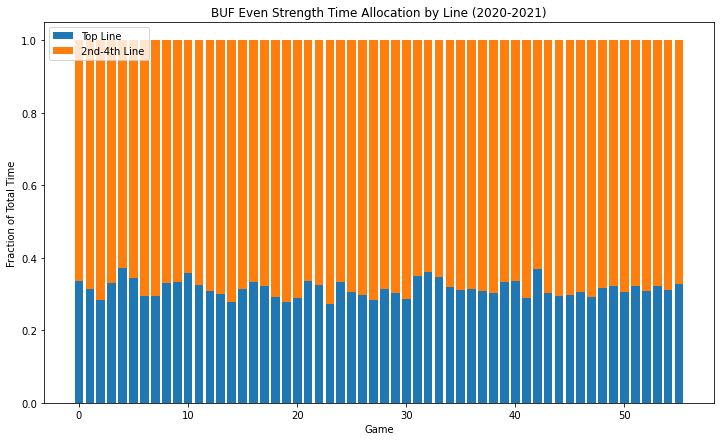

Average Fraction of Even Strength Time by Top Line (regular season):  0.31532356955872215


In [465]:
# Buffalo Sabres
BUF_home_df = home_results_df[home_results_df['team'] == 'BUF']
BUF_away_df = away_results_df[away_results_df['team'] == 'BUF']
BUF_df = pd.concat([BUF_home_df, BUF_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = BUF_df['top line fraction']
remainder_fraction = BUF_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('BUF Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('BUF')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

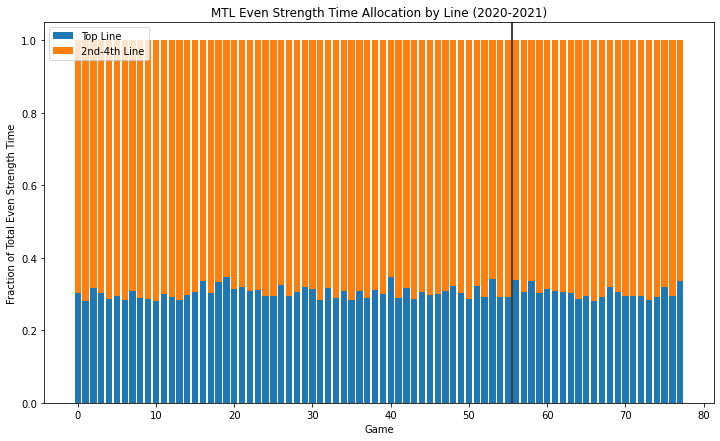

Average Fraction of Even Strength Time by Top Line (regular season):  0.3039884803726055
Average Fraction of Even Strength Time by Top Line (playoffs):  0.30499943639968913
Average Fraction of Even Strength Time by Top Line (combined):  0.3042736218161418


In [466]:
# Montreal Canadiens - playoff team
MTL_home_df = home_results_df[home_results_df['team'] == 'MTL']
MTL_away_df = away_results_df[away_results_df['team'] == 'MTL']
MTL_home_df_po = home_results_df_po[home_results_df_po['team'] == 'MTL']
MTL_away_df_po = away_results_df_po[away_results_df_po['team'] == 'MTL']
MTL_df_reg = pd.concat([MTL_home_df, MTL_away_df], axis=0).sort_index()
MTL_df_po = pd.concat([MTL_home_df_po, MTL_away_df_po], axis=0).sort_index()
MTL_df = pd.concat([MTL_df_reg, MTL_df_po], axis=0)
num_games = len(MTL_df)
labels = [i for i in range(num_games)]
topline_fraction = MTL_df['top line fraction']
remainder_fraction = MTL_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('MTL Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('MTL')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

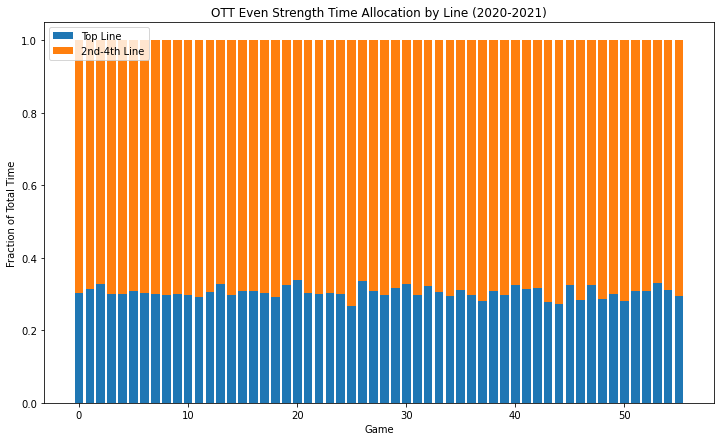

Average Fraction of Even Strength Time by Top Line (regular season):  0.30500685523274734


In [467]:
# Ottawa Senators
OTT_home_df = home_results_df[home_results_df['team'] == 'OTT']
OTT_away_df = away_results_df[away_results_df['team'] == 'OTT']
OTT_df = pd.concat([OTT_home_df, OTT_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = OTT_df['top line fraction']
remainder_fraction = OTT_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('OTT Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('OTT')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

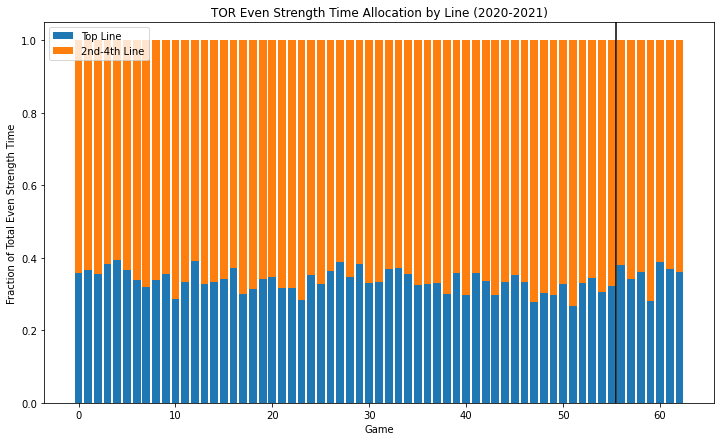

Average Fraction of Even Strength Time by Top Line (regular season):  0.3362680875208801
Average Fraction of Even Strength Time by Top Line (playoffs):  0.35440562414505505
Average Fraction of Even Strength Time by Top Line (combined):  0.3382833693680107


In [468]:
# Toronto Maple Leafs - playoff team
TOR_home_df = home_results_df[home_results_df['team'] == 'TOR']
TOR_away_df = away_results_df[away_results_df['team'] == 'TOR']
TOR_home_df_po = home_results_df_po[home_results_df_po['team'] == 'TOR']
TOR_away_df_po = away_results_df_po[away_results_df_po['team'] == 'TOR']
TOR_df_reg = pd.concat([TOR_home_df, TOR_away_df], axis=0).sort_index()
TOR_df_po = pd.concat([TOR_home_df_po, TOR_away_df_po], axis=0).sort_index()
TOR_df = pd.concat([TOR_df_reg, TOR_df_po], axis=0)
num_games = len(TOR_df)
labels = [i for i in range(num_games)]
topline_fraction = TOR_df['top line fraction']
remainder_fraction = TOR_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('TOR Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('TOR')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

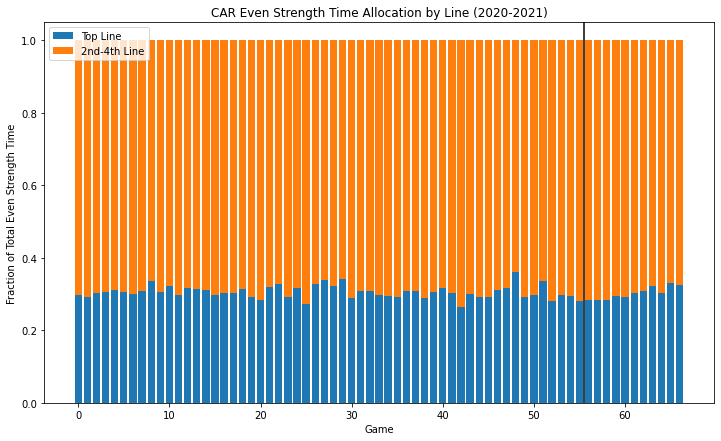

Average Fraction of Even Strength Time by Top Line (regular season):  0.30579040436446137
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3029043983566936
Average Fraction of Even Strength Time by Top Line (combined):  0.30531658248258897


In [469]:
# Carolina Hurricanes - playoff team
CAR_home_df = home_results_df[home_results_df['team'] == 'CAR']
CAR_away_df = away_results_df[away_results_df['team'] == 'CAR']
CAR_home_df_po = home_results_df_po[home_results_df_po['team'] == 'CAR']
CAR_away_df_po = away_results_df_po[away_results_df_po['team'] == 'CAR']
CAR_df_reg = pd.concat([CAR_home_df, CAR_away_df], axis=0).sort_index()
CAR_df_po = pd.concat([CAR_home_df_po, CAR_away_df_po], axis=0).sort_index()
CAR_df = pd.concat([CAR_df_reg, CAR_df_po], axis=0)
num_games = len(CAR_df)
labels = [i for i in range(num_games)]
topline_fraction = CAR_df['top line fraction']
remainder_fraction = CAR_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('CAR Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('CAR')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

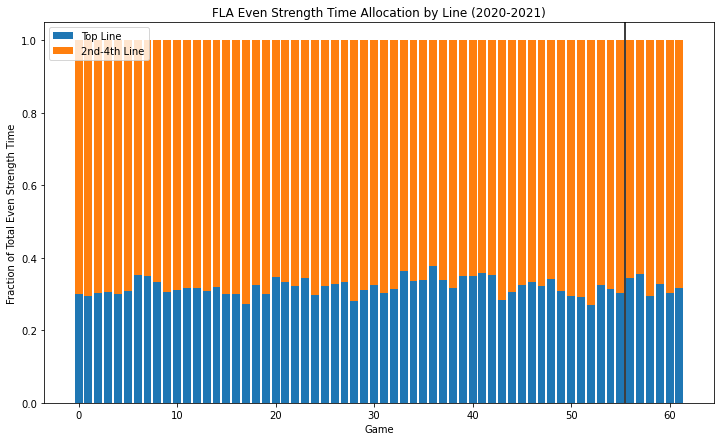

Average Fraction of Even Strength Time by Top Line (regular season):  0.3196530276946556
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3234667969252351
Average Fraction of Even Strength Time by Top Line (combined):  0.32002210213632465


In [470]:
# Florida Panthers - playoff team
FLA_home_df = home_results_df[home_results_df['team'] == 'FLA']
FLA_away_df = away_results_df[away_results_df['team'] == 'FLA']
FLA_home_df_po = home_results_df_po[home_results_df_po['team'] == 'FLA']
FLA_away_df_po = away_results_df_po[away_results_df_po['team'] == 'FLA']
FLA_df_reg = pd.concat([FLA_home_df, FLA_away_df], axis=0).sort_index()
FLA_df_po = pd.concat([FLA_home_df_po, FLA_away_df_po], axis=0).sort_index()
FLA_df = pd.concat([FLA_df_reg, FLA_df_po], axis=0)
num_games = len(FLA_df)
labels = [i for i in range(num_games)]
topline_fraction = FLA_df['top line fraction']
remainder_fraction = FLA_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('FLA Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('FLA')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

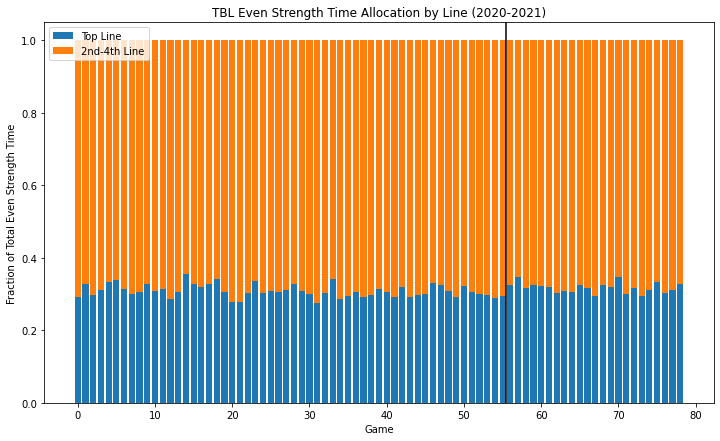

Average Fraction of Even Strength Time by Top Line (regular season):  0.3085956674702138
Average Fraction of Even Strength Time by Top Line (playoffs):  0.31729614083742774
Average Fraction of Even Strength Time by Top Line (combined):  0.31112871667839


In [471]:
# Tampa Bay Lightning - playoff team
TBL_home_df = home_results_df[home_results_df['team'] == 'TBL']
TBL_away_df = away_results_df[away_results_df['team'] == 'TBL']
TBL_home_df_po = home_results_df_po[home_results_df_po['team'] == 'TBL']
TBL_away_df_po = away_results_df_po[away_results_df_po['team'] == 'TBL']
TBL_df_reg = pd.concat([TBL_home_df, TBL_away_df], axis=0).sort_index()
TBL_df_po = pd.concat([TBL_home_df_po, TBL_away_df_po], axis=0).sort_index()
TBL_df = pd.concat([TBL_df_reg, TBL_df_po], axis=0)
num_games = len(TBL_df)
labels = [i for i in range(num_games)]
topline_fraction = TBL_df['top line fraction']
remainder_fraction = TBL_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('TBL Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('TBL')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

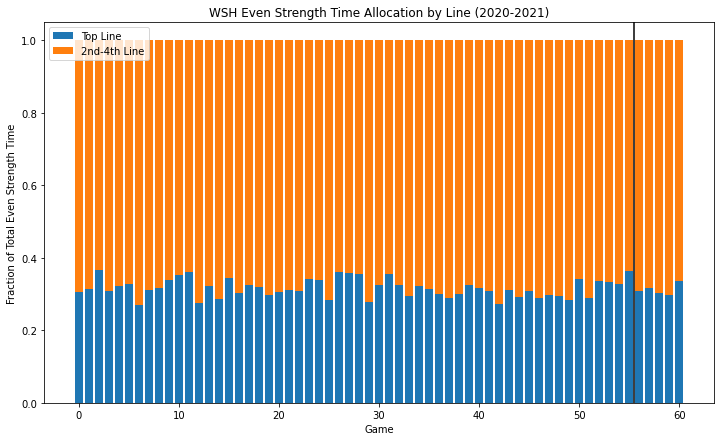

Average Fraction of Even Strength Time by Top Line (regular season):  0.31648828117563593
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3116206650591219
Average Fraction of Even Strength Time by Top Line (combined):  0.31608929624805276


In [472]:
# Washington Capitals - playoff team
WSH_home_df = home_results_df[home_results_df['team'] == 'WSH']
WSH_away_df = away_results_df[away_results_df['team'] == 'WSH']
WSH_home_df_po = home_results_df_po[home_results_df_po['team'] == 'WSH']
WSH_away_df_po = away_results_df_po[away_results_df_po['team'] == 'WSH']
WSH_df_reg = pd.concat([WSH_home_df, WSH_away_df], axis=0).sort_index()
WSH_df_po = pd.concat([WSH_home_df_po, WSH_away_df_po], axis=0).sort_index()
WSH_df = pd.concat([WSH_df_reg, WSH_df_po], axis=0)
num_games = len(WSH_df)
labels = [i for i in range(num_games)]
topline_fraction = WSH_df['top line fraction']
remainder_fraction = WSH_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('WSH Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('WSH')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

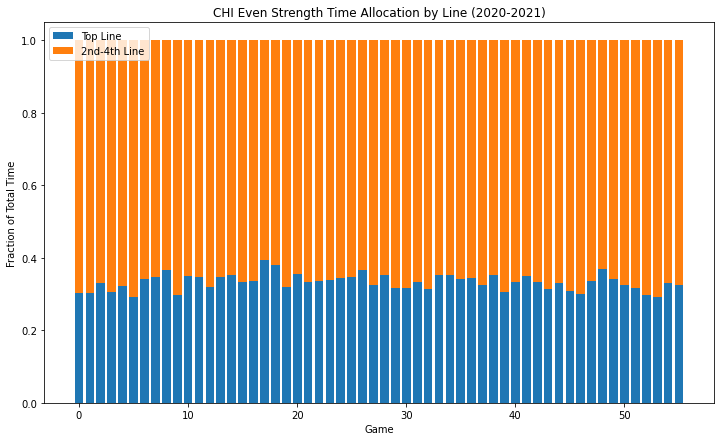

Average Fraction of Even Strength Time by Top Line (regular season):  0.3329534525725049


In [473]:
# Chicago Blackhawks
CHI_home_df = home_results_df[home_results_df['team'] == 'CHI']
CHI_away_df = away_results_df[away_results_df['team'] == 'CHI']
CHI_df = pd.concat([CHI_home_df, CHI_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = CHI_df['top line fraction']
remainder_fraction = CHI_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('CHI Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CHI')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

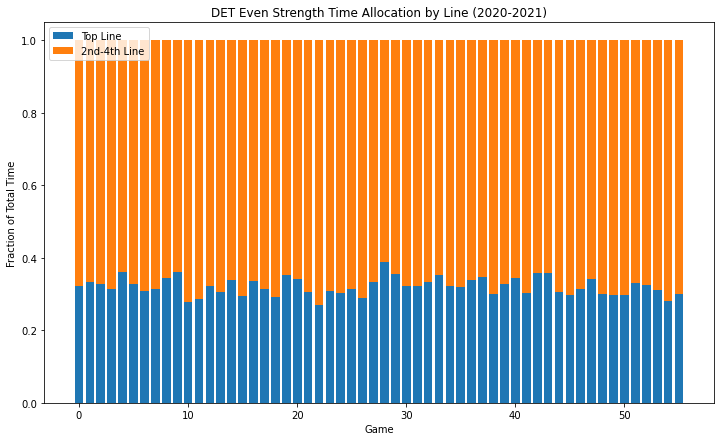

Average Fraction of Even Strength Time by Top Line (regular season):  0.321429334355988


In [474]:
# Detroit Red Wings
DET_home_df = home_results_df[home_results_df['team'] == 'DET']
DET_away_df = away_results_df[away_results_df['team'] == 'DET']
DET_df = pd.concat([DET_home_df, DET_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = DET_df['top line fraction']
remainder_fraction = DET_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('DET Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('DET')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

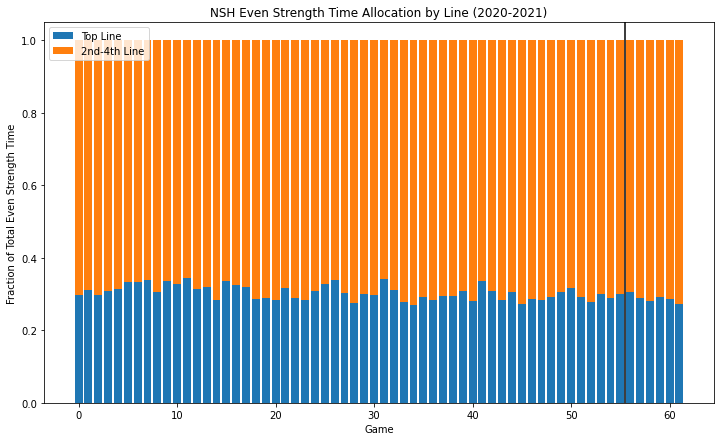

Average Fraction of Even Strength Time by Top Line (regular season):  0.3044671594325281
Average Fraction of Even Strength Time by Top Line (playoffs):  0.28765281900243084
Average Fraction of Even Strength Time by Top Line (combined):  0.30283996519735745


In [475]:
# Nashville Predators - playoff team
NSH_home_df = home_results_df[home_results_df['team'] == 'NSH']
NSH_away_df = away_results_df[away_results_df['team'] == 'NSH']
NSH_home_df_po = home_results_df_po[home_results_df_po['team'] == 'NSH']
NSH_away_df_po = away_results_df_po[away_results_df_po['team'] == 'NSH']
NSH_df_reg = pd.concat([NSH_home_df, NSH_away_df], axis=0).sort_index()
NSH_df_po = pd.concat([NSH_home_df_po, NSH_away_df_po], axis=0).sort_index()
NSH_df = pd.concat([NSH_df_reg, NSH_df_po], axis=0)
num_games = len(NSH_df)
labels = [i for i in range(num_games)]
topline_fraction = NSH_df['top line fraction']
remainder_fraction = NSH_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('NSH Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('NSH')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

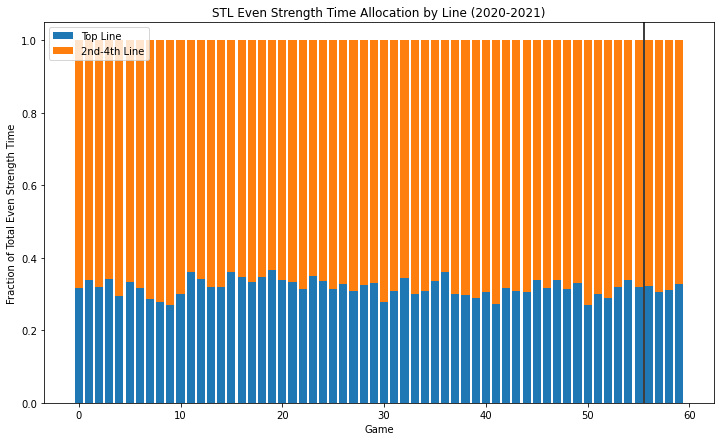

Average Fraction of Even Strength Time by Top Line (regular season):  0.31932785575360606
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3172041331721294
Average Fraction of Even Strength Time by Top Line (combined):  0.3191862742481742


In [476]:
# St. Louis Blues - playoff team
STL_home_df = home_results_df[home_results_df['team'] == 'STL']
STL_away_df = away_results_df[away_results_df['team'] == 'STL']
STL_home_df_po = home_results_df_po[home_results_df_po['team'] == 'STL']
STL_away_df_po = away_results_df_po[away_results_df_po['team'] == 'STL']
STL_df_reg = pd.concat([STL_home_df, STL_away_df], axis=0).sort_index()
STL_df_po = pd.concat([STL_home_df_po, STL_away_df_po], axis=0).sort_index()
STL_df = pd.concat([STL_df_reg, STL_df_po], axis=0)
num_games = len(STL_df)
labels = [i for i in range(num_games)]
topline_fraction = STL_df['top line fraction']
remainder_fraction = STL_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('STL Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('STL')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

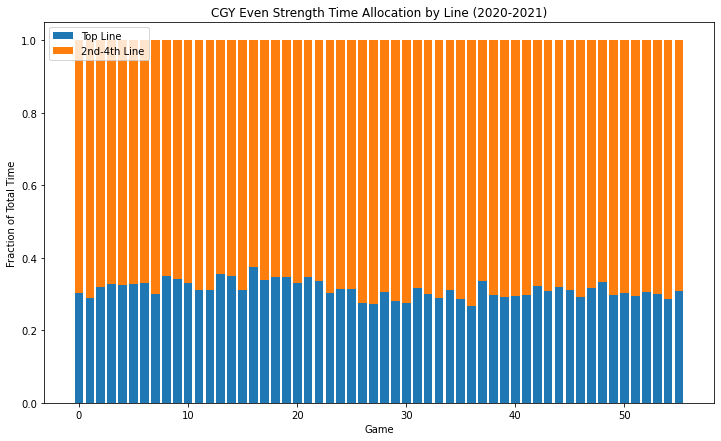

Average Fraction of Even Strength Time by Top Line (regular season):  0.31317778871099156


In [477]:
# Calgary Flames
CGY_home_df = home_results_df[home_results_df['team'] == 'CGY']
CGY_away_df = away_results_df[away_results_df['team'] == 'CGY']
CGY_df = pd.concat([CGY_home_df, CGY_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = CGY_df['top line fraction']
remainder_fraction = CGY_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('CGY Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CGY')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

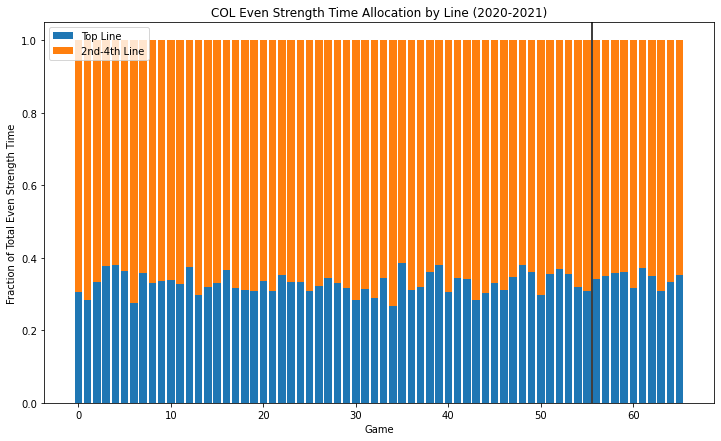

Average Fraction of Even Strength Time by Top Line (regular season):  0.3300541507646963
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3446146672748567
Average Fraction of Even Strength Time by Top Line (combined):  0.3322602896298721


In [478]:
# Colorado Avalanche - playoff team
COL_home_df = home_results_df[home_results_df['team'] == 'COL']
COL_away_df = away_results_df[away_results_df['team'] == 'COL']
COL_home_df_po = home_results_df_po[home_results_df_po['team'] == 'COL']
COL_away_df_po = away_results_df_po[away_results_df_po['team'] == 'COL']
COL_df_reg = pd.concat([COL_home_df, COL_away_df], axis=0).sort_index()
COL_df_po = pd.concat([COL_home_df_po, COL_away_df_po], axis=0).sort_index()
COL_df = pd.concat([COL_df_reg, COL_df_po], axis=0)
num_games = len(COL_df)
labels = [i for i in range(num_games)]
topline_fraction = COL_df['top line fraction']
remainder_fraction = COL_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('COL Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('COL')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

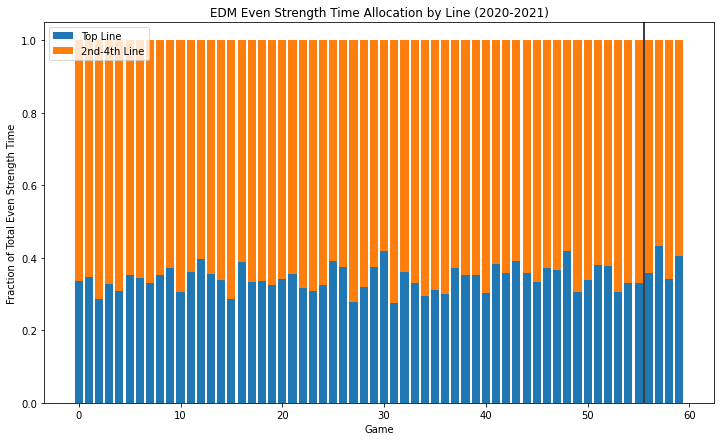

Average Fraction of Even Strength Time by Top Line (regular season):  0.34254939660312844
Average Fraction of Even Strength Time by Top Line (playoffs):  0.38428885690362974
Average Fraction of Even Strength Time by Top Line (combined):  0.34533202728982865


In [479]:
# Edmonton Oilers - playoff team
EDM_home_df = home_results_df[home_results_df['team'] == 'EDM']
EDM_away_df = away_results_df[away_results_df['team'] == 'EDM']
EDM_home_df_po = home_results_df_po[home_results_df_po['team'] == 'EDM']
EDM_away_df_po = away_results_df_po[away_results_df_po['team'] == 'EDM']
EDM_df_reg = pd.concat([EDM_home_df, EDM_away_df], axis=0).sort_index()
EDM_df_po = pd.concat([EDM_home_df_po, EDM_away_df_po], axis=0).sort_index()
EDM_df = pd.concat([EDM_df_reg, EDM_df_po], axis=0)
num_games = len(EDM_df)
labels = [i for i in range(num_games)]
topline_fraction = EDM_df['top line fraction']
remainder_fraction = EDM_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('EDM Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('EDM')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

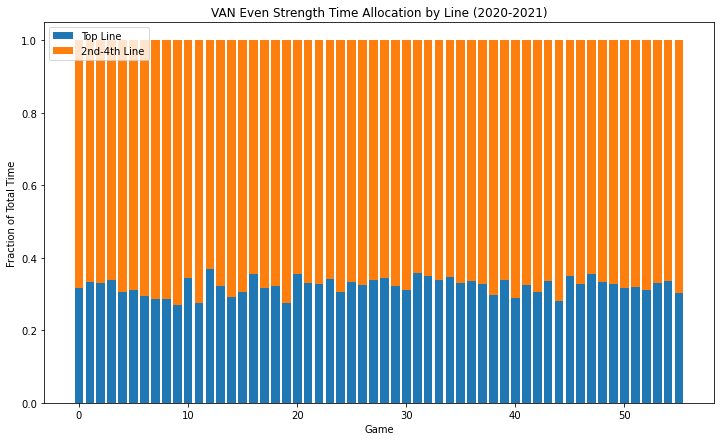

Average Fraction of Even Strength Time by Top Line (regular season):  0.322570877226387


In [480]:
# Vancouver Canucks
VAN_home_df = home_results_df[home_results_df['team'] == 'VAN']
VAN_away_df = away_results_df[away_results_df['team'] == 'VAN']
VAN_df = pd.concat([VAN_home_df, VAN_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = VAN_df['top line fraction']
remainder_fraction = VAN_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('VAN Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('VAN')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

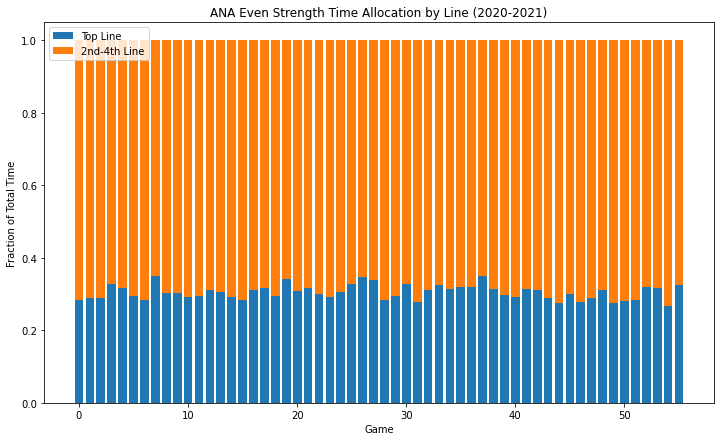

Average Fraction of Even Strength Time by Top Line (regular season):  0.30501367163045123


In [481]:
# Anaheim Ducks
ANA_home_df = home_results_df[home_results_df['team'] == 'ANA']
ANA_away_df = away_results_df[away_results_df['team'] == 'ANA']
ANA_df = pd.concat([ANA_home_df, ANA_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = ANA_df['top line fraction']
remainder_fraction = ANA_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('ANA Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('ANA')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

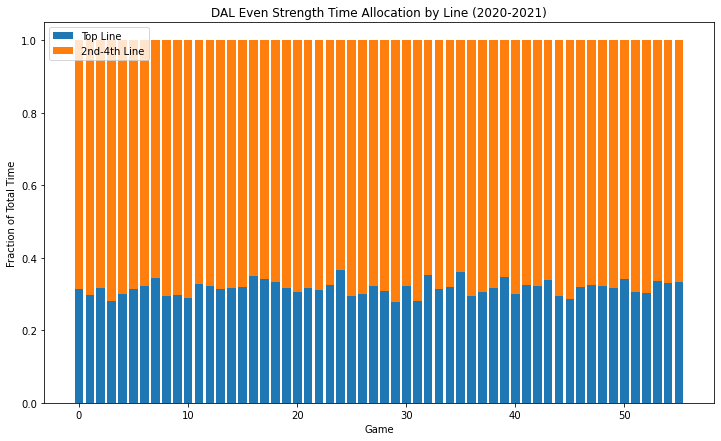

Average Fraction of Even Strength Time by Top Line (regular season):  0.3171022693793297


In [482]:
# Dallas Stars
DAL_home_df = home_results_df[home_results_df['team'] == 'DAL']
DAL_away_df = away_results_df[away_results_df['team'] == 'DAL']
DAL_df = pd.concat([DAL_home_df, DAL_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = DAL_df['top line fraction']
remainder_fraction = DAL_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('DAL Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('DAL')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

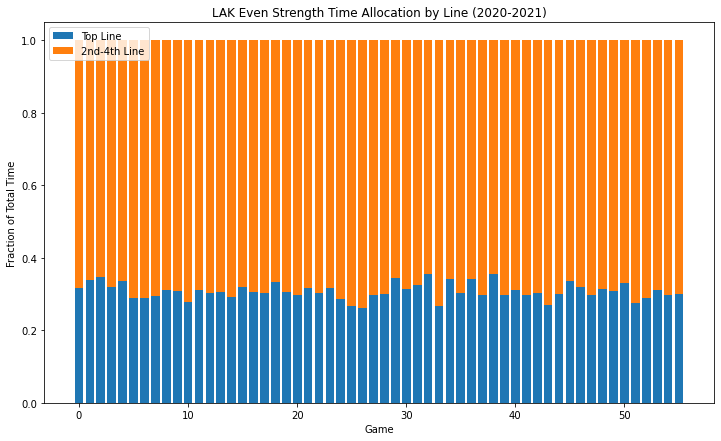

Average Fraction of Even Strength Time by Top Line (regular season):  0.30827002758970246


In [483]:
# Los Angeles Kings
LAK_home_df = home_results_df[home_results_df['team'] == 'LAK']
LAK_away_df = away_results_df[away_results_df['team'] == 'LAK']
LAK_df = pd.concat([LAK_home_df, LAK_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = LAK_df['top line fraction']
remainder_fraction = LAK_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('LAK Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('LAK')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

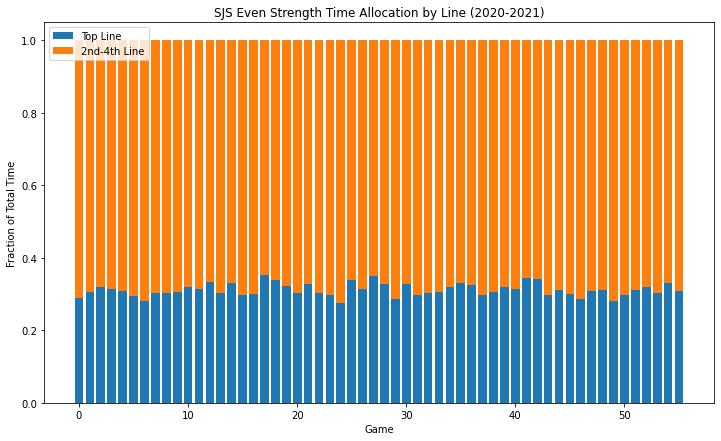

Average Fraction of Even Strength Time by Top Line (regular season):  0.31188024484322924


In [484]:
# San Jose Sharks
SJS_home_df = home_results_df[home_results_df['team'] == 'SJS']
SJS_away_df = away_results_df[away_results_df['team'] == 'SJS']
SJS_df = pd.concat([SJS_home_df, SJS_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = SJS_df['top line fraction']
remainder_fraction = SJS_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('SJS Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('SJS')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

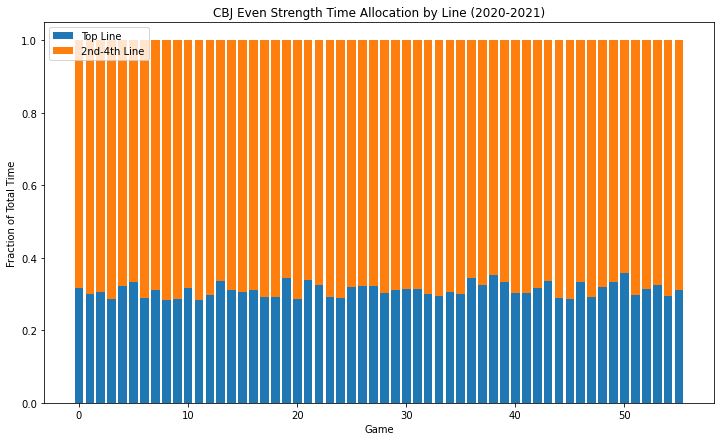

Average Fraction of Even Strength Time by Top Line (regular season):  0.31146510695360724


In [485]:
# Columbus Blue Jackets
CBJ_home_df = home_results_df[home_results_df['team'] == 'CBJ']
CBJ_away_df = away_results_df[away_results_df['team'] == 'CBJ']
CBJ_df = pd.concat([CBJ_home_df, CBJ_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = CBJ_df['top line fraction']
remainder_fraction = CBJ_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('CBJ Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CBJ')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

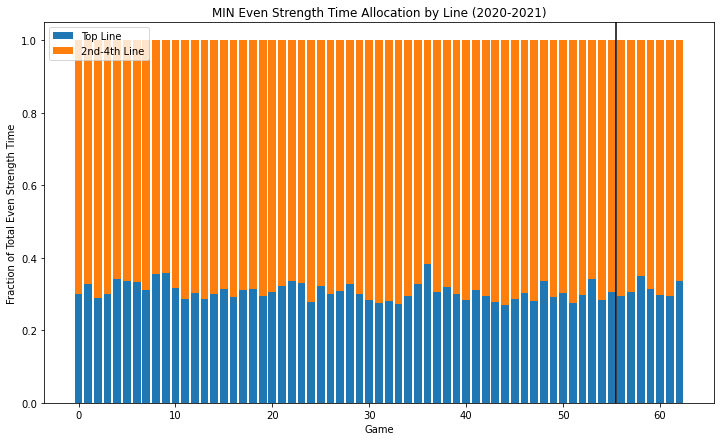

Average Fraction of Even Strength Time by Top Line (regular season):  0.30699424289886695
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3132084172222412
Average Fraction of Even Strength Time by Top Line (combined):  0.30768470671257525


In [486]:
# Minnesota Wild - playoff team
MIN_home_df = home_results_df[home_results_df['team'] == 'MIN']
MIN_away_df = away_results_df[away_results_df['team'] == 'MIN']
MIN_home_df_po = home_results_df_po[home_results_df_po['team'] == 'MIN']
MIN_away_df_po = away_results_df_po[away_results_df_po['team'] == 'MIN']
MIN_df_reg = pd.concat([MIN_home_df, MIN_away_df], axis=0).sort_index()
MIN_df_po = pd.concat([MIN_home_df_po, MIN_away_df_po], axis=0).sort_index()
MIN_df = pd.concat([MIN_df_reg, MIN_df_po], axis=0)
num_games = len(MIN_df)
labels = [i for i in range(num_games)]
topline_fraction = MIN_df['top line fraction']
remainder_fraction = MIN_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('MIN Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('MIN')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

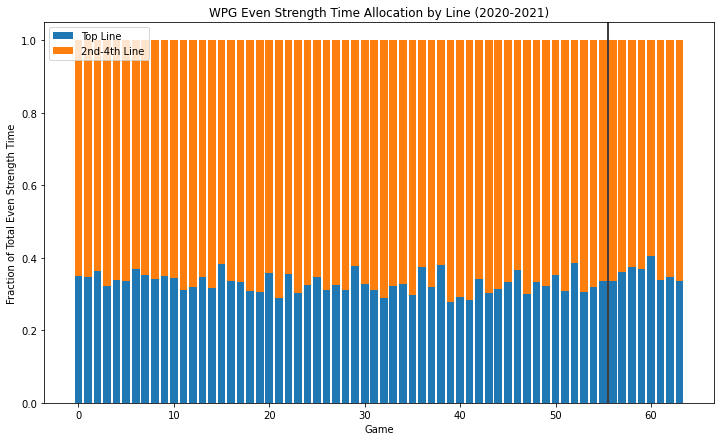

Average Fraction of Even Strength Time by Top Line (regular season):  0.3302187331369602
Average Fraction of Even Strength Time by Top Line (playoffs):  0.35896206102435235
Average Fraction of Even Strength Time by Top Line (combined):  0.3338116491228841


In [487]:
# Winnipeg Jets - playoff team
WPG_home_df = home_results_df[home_results_df['team'] == 'WPG']
WPG_away_df = away_results_df[away_results_df['team'] == 'WPG']
WPG_home_df_po = home_results_df_po[home_results_df_po['team'] == 'WPG']
WPG_away_df_po = away_results_df_po[away_results_df_po['team'] == 'WPG']
WPG_df_reg = pd.concat([WPG_home_df, WPG_away_df], axis=0).sort_index()
WPG_df_po = pd.concat([WPG_home_df_po, WPG_away_df_po], axis=0).sort_index()
WPG_df = pd.concat([WPG_df_reg, WPG_df_po], axis=0)
num_games = len(WPG_df)
labels = [i for i in range(num_games)]
topline_fraction = WPG_df['top line fraction']
remainder_fraction = WPG_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('WPG Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('WPG')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

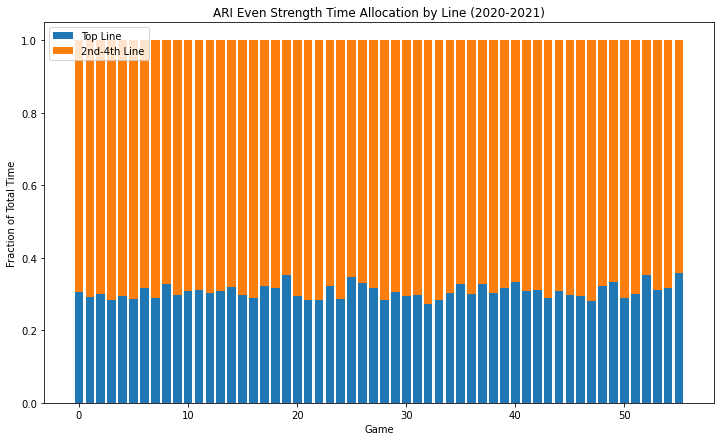

Average Fraction of Even Strength Time by Top Line (regular season):  0.3072895736732423


In [488]:
# Arizona Coyotes
ARI_home_df = home_results_df[home_results_df['team'] == 'ARI']
ARI_away_df = away_results_df[away_results_df['team'] == 'ARI']
ARI_df = pd.concat([ARI_home_df, ARI_away_df], axis=0).sort_index()
labels = [i for i in range(56)]
topline_fraction = ARI_df['top line fraction']
remainder_fraction = ARI_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Time')
ax.set_xlabel('Game')
ax.set_title('ARI Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('ARI')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append('N/A')
combined_avg_list.append('N/A')

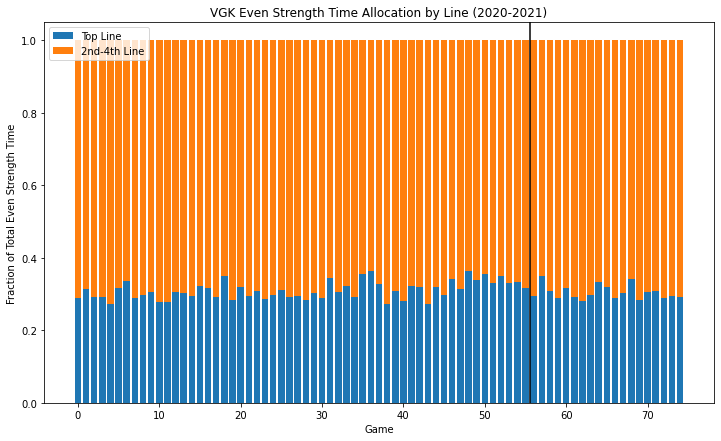

Average Fraction of Even Strength Time by Top Line (regular season):  0.31052703880940474
Average Fraction of Even Strength Time by Top Line (playoffs):  0.3048595172068353
Average Fraction of Even Strength Time by Top Line (combined):  0.30909126667008713


In [489]:
# Vegas Golden Knights - playoff team
VGK_home_df = home_results_df[home_results_df['team'] == 'VGK']
VGK_away_df = away_results_df[away_results_df['team'] == 'VGK']
VGK_home_df_po = home_results_df_po[home_results_df_po['team'] == 'VGK']
VGK_away_df_po = away_results_df_po[away_results_df_po['team'] == 'VGK']
VGK_df_reg = pd.concat([VGK_home_df, VGK_away_df], axis=0).sort_index()
VGK_df_po = pd.concat([VGK_home_df_po, VGK_away_df_po], axis=0).sort_index()
VGK_df = pd.concat([VGK_df_reg, VGK_df_po], axis=0)
num_games = len(VGK_df)
labels = [i for i in range(num_games)]
topline_fraction = VGK_df['top line fraction']
remainder_fraction = VGK_df['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('VGK Even Strength Time Allocation by Line (2020-2021)')
ax.legend(loc='upper left')
plt.axvline(x=55.5, color='k')
plt.show()
reg_season_avg = sum(topline_fraction[:56]/56)
playoff_avg = sum(topline_fraction[56:])/(num_games-56)
combined_avg = sum(topline_fraction)/num_games
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
print('Average Fraction of Even Strength Time by Top Line (playoffs): ', 
      playoff_avg)
print('Average Fraction of Even Strength Time by Top Line (combined): ', 
      combined_avg)
team_abbrev_list.append('VGK')
reg_season_avg_list.append(reg_season_avg)
playoff_avg_list.append(playoff_avg)
combined_avg_list.append(combined_avg)

In [490]:
# combine result lists into dataframe
summary_20202021_df = pd.DataFrame({
    'team': team_abbrev_list,
    'regular season average': reg_season_avg_list,
    'playoff average': playoff_avg_list,
    'combined season average': combined_avg_list
})

In [491]:
pd.options.display.float_format = '{:,.5f}'.format
summary_20202021_df

,team,regular season average,playoff average,combined season average
0,NJD,0.31621,N/A,N/A
1,NYI,0.30674,0.29636,0.30411
2,NYR,0.30967,N/A,N/A
3,PHI,0.30025,N/A,N/A
4,PIT,0.33386,0.31281,0.33182
5,BOS,0.30431,0.31853,0.30665
6,BUF,0.31532,N/A,N/A
7,MTL,0.30399,0.30500,0.30427
8,OTT,0.30501,N/A,N/A
9,TOR,0.33627,0.35441,0.33828


In [492]:
# formatting for better readability
pd.options.display.float_format = '{:,.3f}%'.format
formatted_20202021 = summary_20202021_df
formatted_20202021['regular season average'] = formatted_20202021['regular season average'].apply(lambda x: x*100)
formatted_20202021['playoff average'] = np.where(formatted_20202021['playoff average']!='N/A', 
                              formatted_20202021['playoff average']*100, formatted_20202021['playoff average'])
formatted_20202021['combined season average'] = np.where(formatted_20202021['combined season average']!='N/A', 
                              formatted_20202021['combined season average']*100, formatted_20202021['combined season average'])

In [493]:
formatted_20202021.sort_values(by='regular season average', ascending=False)

,team,regular season average,playoff average,combined season average
20,EDM,34.255%,38.429%,34.533%
9,TOR,33.627%,35.441%,33.828%
4,PIT,33.386%,31.281%,33.182%
14,CHI,33.295%,N/A,N/A
28,WPG,33.022%,35.896%,33.381%
19,COL,33.005%,34.461%,33.226%
21,VAN,32.257%,N/A,N/A
15,DET,32.143%,N/A,N/A
11,FLA,31.965%,32.347%,32.002%
17,STL,31.933%,31.720%,31.919%


In [494]:
playoff_teams_avg = (summary_20202021_df.loc[summary_20202021_df['playoff average'] != 'N/A',
                                             'regular season average'].sum())/16
non_playoff_teams_avg = (summary_20202021_df.loc[summary_20202021_df['playoff average'] == 'N/A',
                                             'regular season average'].sum())/15

print('Average fraction of even strength time by top line in regular season for teams that made the playoffs: ',
      "{:.3f}%".format(playoff_teams_avg))
print('Average fraction of even strength time by top line in regular season for teams that did not make the playoffs: ',
      "{:.3f}%".format(non_playoff_teams_avg))

Average fraction of even strength time by top line in regular season for teams that made the playoffs:  31.749%
Average fraction of even strength time by top line in regular season for teams that did not make the playoffs:  31.317%


## 2021-2022

In [515]:
# create lists to store data for all teams for easy comparison
team_abbrev_list = []
reg_season_avg_list = []

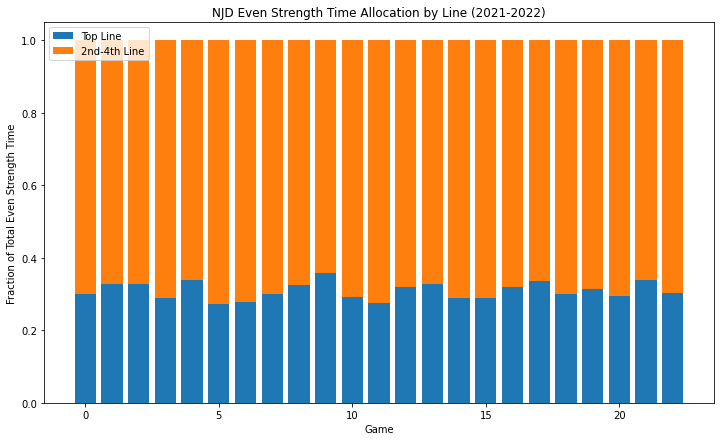

Average Fraction of Even Strength Time by Top Line (regular season):  0.3094058032500349


In [516]:
# New Jersey Devils
NJD_home_df = home_results_df[home_results_df['team'] == 'NJD']
NJD_away_df = away_results_df[away_results_df['team'] == 'NJD']
NJD_df22 = pd.concat([NJD_home_df, NJD_away_df], axis=0).sort_index()
num_games = len(NJD_df22)
labels = [i for i in range(num_games)]
topline_fraction = NJD_df22['top line fraction']
remainder_fraction = NJD_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('NJD Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('NJD')
reg_season_avg_list.append(reg_season_avg)

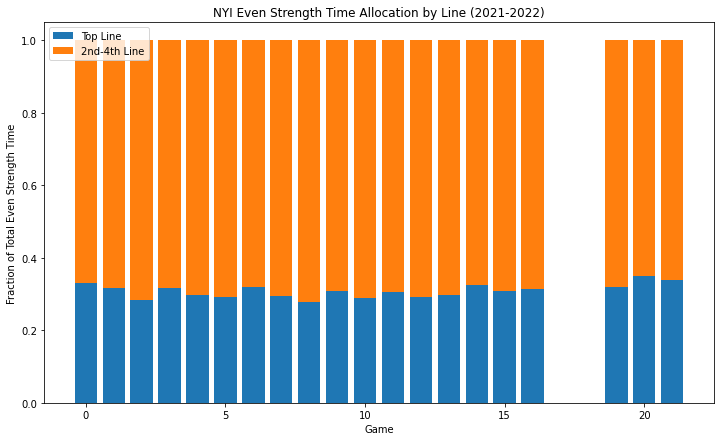

Average Fraction of Even Strength Time by Top Line (regular season):  0.3088382443393191


In [517]:
# New York Islanders
NYI_home_df = home_results_df[home_results_df['team'] == 'NYI']
NYI_away_df = away_results_df[away_results_df['team'] == 'NYI']
NYI_df22 = pd.concat([NYI_home_df, NYI_away_df], axis=0).sort_index()
num_games = len(NYI_df22) # NYI had 2 games canceled
labels = [i for i in range(num_games)]
topline_fraction = NYI_df22['top line fraction']
remainder_fraction = NYI_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('NYI Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/(num_games-2))
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('NYI')
reg_season_avg_list.append(reg_season_avg)

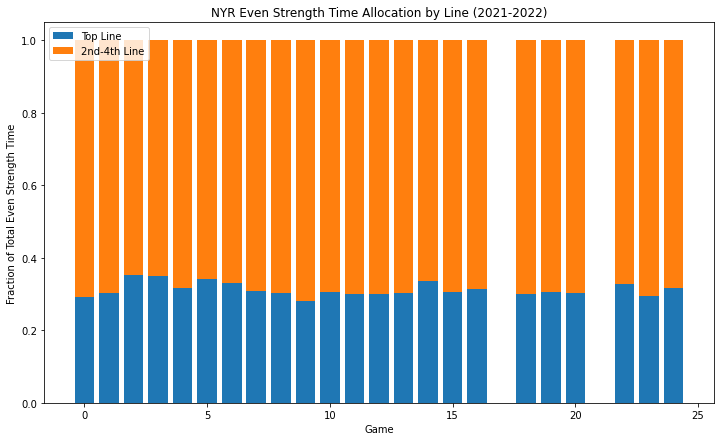

Average Fraction of Even Strength Time by Top Line (regular season):  0.31245995218404493


In [518]:
# New York Rangers
NYR_home_df = home_results_df[home_results_df['team'] == 'NYR']
NYR_away_df = away_results_df[away_results_df['team'] == 'NYR']
NYR_df22 = pd.concat([NYR_home_df, NYR_away_df], axis=0).sort_index()
num_games = len(NYR_df22) # NYR had 2 games canceled
labels = [i for i in range(num_games)]
topline_fraction = NYR_df22['top line fraction']
remainder_fraction = NYR_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('NYR Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/(num_games-2))
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('NYR')
reg_season_avg_list.append(reg_season_avg)

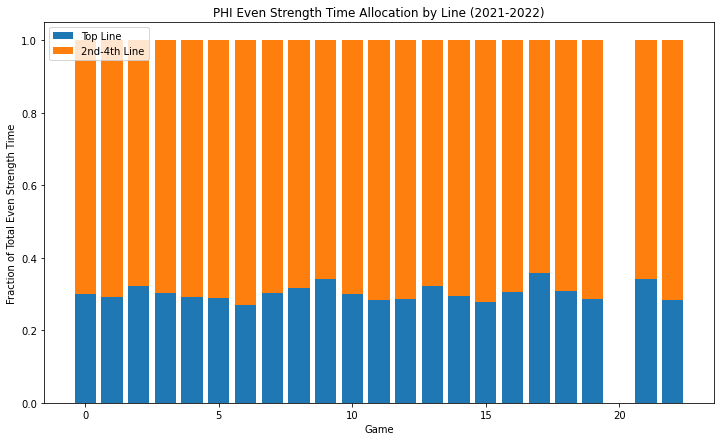

Average Fraction of Even Strength Time by Top Line (regular season):  0.3041518863145539


In [519]:
# Philadelphia Flyers
PHI_home_df = home_results_df[home_results_df['team'] == 'PHI']
PHI_away_df = away_results_df[away_results_df['team'] == 'PHI']
PHI_df22 = pd.concat([PHI_home_df, PHI_away_df], axis=0).sort_index()
num_games = len(PHI_df22) # PHI had 1 game canceled
labels = [i for i in range(num_games)]
topline_fraction = PHI_df22['top line fraction']
remainder_fraction = PHI_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('PHI Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/(num_games-1))
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('PHI')
reg_season_avg_list.append(reg_season_avg)

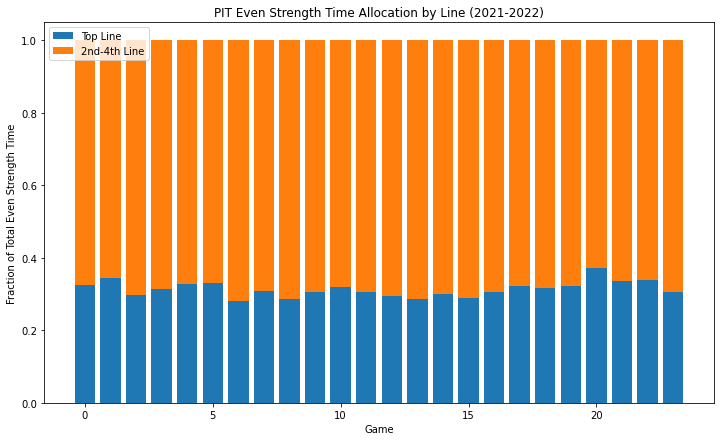

Average Fraction of Even Strength Time by Top Line (regular season):  0.3140586658149945


In [520]:
# Pittsburgh Penguins
PIT_home_df = home_results_df[home_results_df['team'] == 'PIT']
PIT_away_df = away_results_df[away_results_df['team'] == 'PIT']
PIT_df22 = pd.concat([PIT_home_df, PIT_away_df], axis=0).sort_index()
num_games = len(PIT_df22)
labels = [i for i in range(num_games)]
topline_fraction = PIT_df22['top line fraction']
remainder_fraction = PIT_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('PIT Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('PIT')
reg_season_avg_list.append(reg_season_avg)

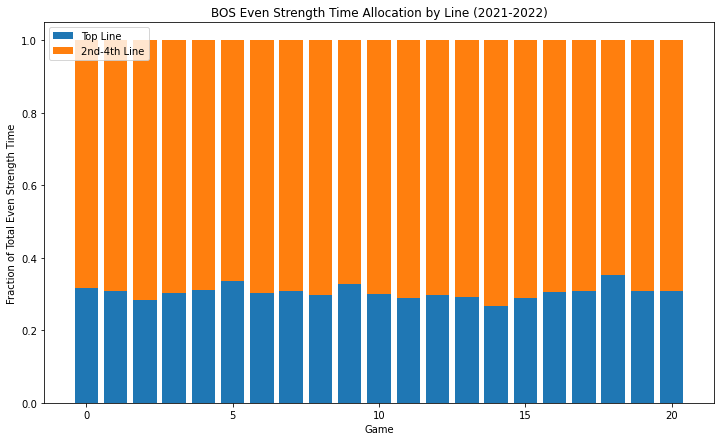

Average Fraction of Even Strength Time by Top Line (regular season):  0.305158368690673


In [521]:
# Boston Bruins
BOS_home_df = home_results_df[home_results_df['team'] == 'BOS']
BOS_away_df = away_results_df[away_results_df['team'] == 'BOS']
BOS_df22 = pd.concat([BOS_home_df, BOS_away_df], axis=0).sort_index()
num_games = len(BOS_df22)
labels = [i for i in range(num_games)]
topline_fraction = BOS_df22['top line fraction']
remainder_fraction = BOS_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('BOS Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('BOS')
reg_season_avg_list.append(reg_season_avg)

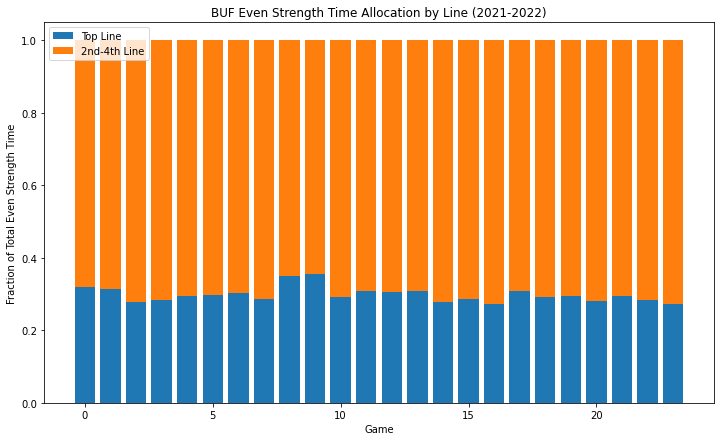

Average Fraction of Even Strength Time by Top Line (regular season):  0.2983559128539826


In [522]:
# Buffalo Sabres
BUF_home_df = home_results_df[home_results_df['team'] == 'BUF']
BUF_away_df = away_results_df[away_results_df['team'] == 'BUF']
BUF_df22 = pd.concat([BUF_home_df, BUF_away_df], axis=0).sort_index()
num_games = len(BUF_df22)
labels = [i for i in range(num_games)]
topline_fraction = BUF_df22['top line fraction']
remainder_fraction = BUF_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('BUF Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('BUF')
reg_season_avg_list.append(reg_season_avg)

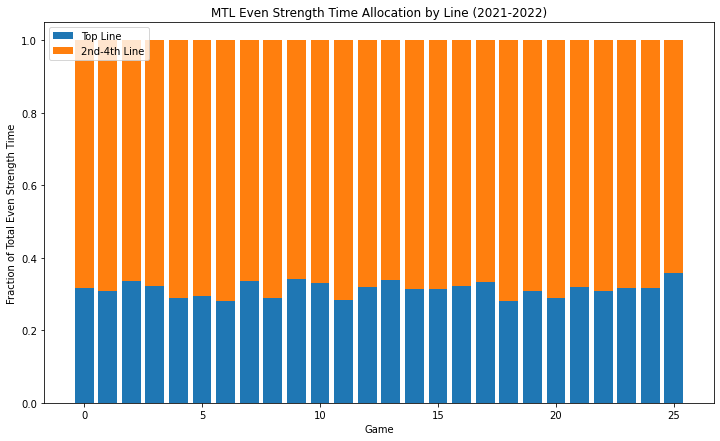

Average Fraction of Even Strength Time by Top Line (regular season):  0.314253842723617


In [523]:
# Montreal Canadiens
MTL_home_df = home_results_df[home_results_df['team'] == 'MTL']
MTL_away_df = away_results_df[away_results_df['team'] == 'MTL']
MTL_df22 = pd.concat([MTL_home_df, MTL_away_df], axis=0).sort_index()
num_games = len(MTL_df22)
labels = [i for i in range(num_games)]
topline_fraction = MTL_df22['top line fraction']
remainder_fraction = MTL_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('MTL Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('MTL')
reg_season_avg_list.append(reg_season_avg)

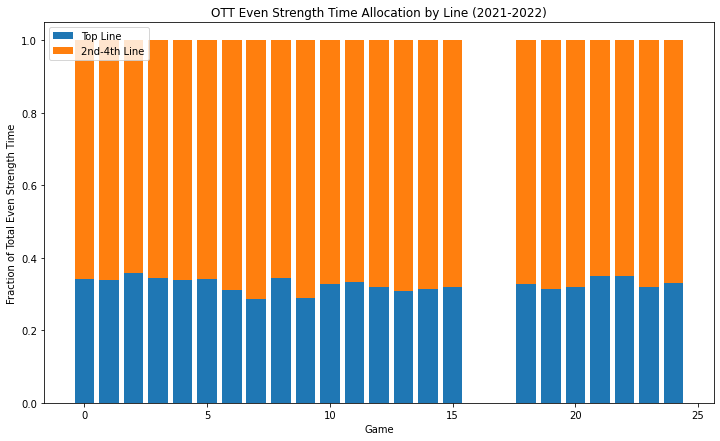

Average Fraction of Even Strength Time by Top Line (regular season):  0.32749622521318006


In [524]:
# Ottawa Senators
OTT_home_df = home_results_df[home_results_df['team'] == 'OTT']
OTT_away_df = away_results_df[away_results_df['team'] == 'OTT']
OTT_df22 = pd.concat([OTT_home_df, OTT_away_df], axis=0).sort_index()
num_games = len(OTT_df22) # OTT had 2 games canceled
OTT_df22 = OTT_df22.fillna(value=0)
labels = [i for i in range(num_games)]
topline_fraction = OTT_df22['top line fraction']
remainder_fraction = OTT_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('OTT Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/(num_games-2))
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('OTT')
reg_season_avg_list.append(reg_season_avg)

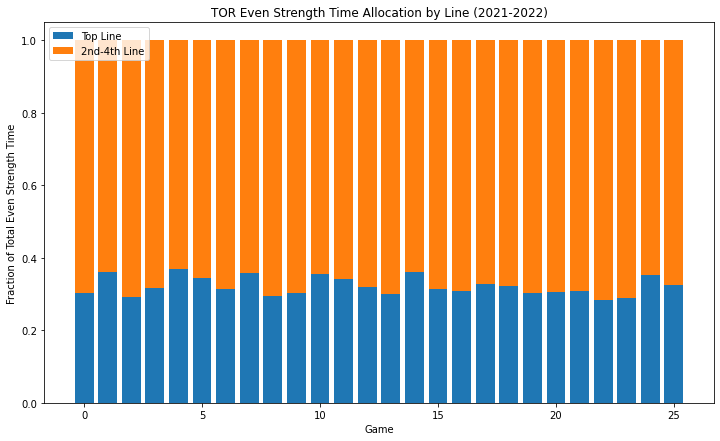

Average Fraction of Even Strength Time by Top Line (regular season):  0.3220029438407237


In [525]:
# Toronto Maple Leafs
TOR_home_df = home_results_df[home_results_df['team'] == 'TOR']
TOR_away_df = away_results_df[away_results_df['team'] == 'TOR']
TOR_df22 = pd.concat([TOR_home_df, TOR_away_df], axis=0).sort_index()
num_games = len(TOR_df22)
labels = [i for i in range(num_games)]
topline_fraction = TOR_df22['top line fraction']
remainder_fraction = TOR_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('TOR Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('TOR')
reg_season_avg_list.append(reg_season_avg)

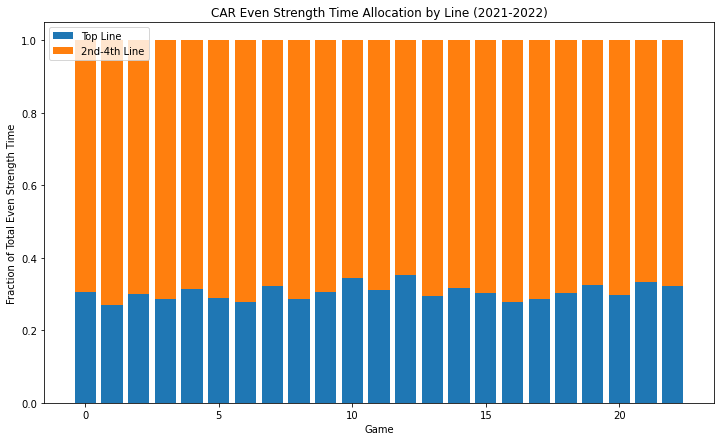

Average Fraction of Even Strength Time by Top Line (regular season):  0.30555218598058725


In [526]:
# Carolina Hurricanes
CAR_home_df = home_results_df[home_results_df['team'] == 'CAR']
CAR_away_df = away_results_df[away_results_df['team'] == 'CAR']
CAR_df22 = pd.concat([CAR_home_df, CAR_away_df], axis=0).sort_index()
num_games = len(CAR_df22)
labels = [i for i in range(num_games)]
topline_fraction = CAR_df22['top line fraction']
remainder_fraction = CAR_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('CAR Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CAR')
reg_season_avg_list.append(reg_season_avg)

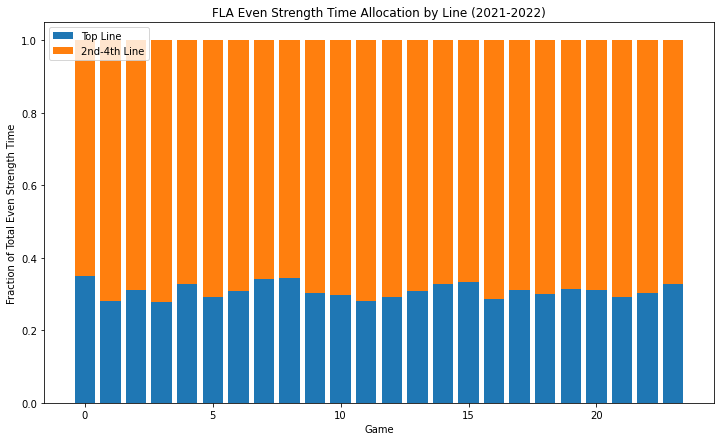

Average Fraction of Even Strength Time by Top Line (regular season):  0.30921692725971495


In [527]:
# Florida Panthers
FLA_home_df = home_results_df[home_results_df['team'] == 'FLA']
FLA_away_df = away_results_df[away_results_df['team'] == 'FLA']
FLA_df22 = pd.concat([FLA_home_df, FLA_away_df], axis=0).sort_index()
num_games = len(FLA_df22)
labels = [i for i in range(num_games)]
topline_fraction = FLA_df22['top line fraction']
remainder_fraction = FLA_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('FLA Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('FLA')
reg_season_avg_list.append(reg_season_avg)

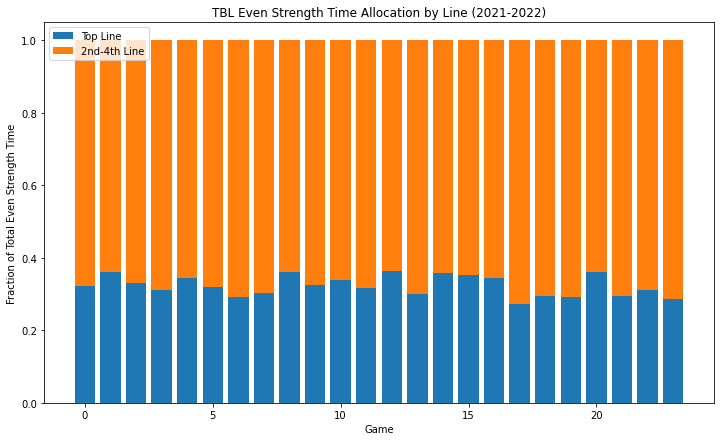

Average Fraction of Even Strength Time by Top Line (regular season):  0.3234160976550631


In [528]:
# Tampa Bay Lightning
TBL_home_df = home_results_df[home_results_df['team'] == 'TBL']
TBL_away_df = away_results_df[away_results_df['team'] == 'TBL']
TBL_df22 = pd.concat([TBL_home_df, TBL_away_df], axis=0).sort_index()
num_games = len(TBL_df22)
labels = [i for i in range(num_games)]
topline_fraction = TBL_df22['top line fraction']
remainder_fraction = TBL_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('TBL Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('TBL')
reg_season_avg_list.append(reg_season_avg)

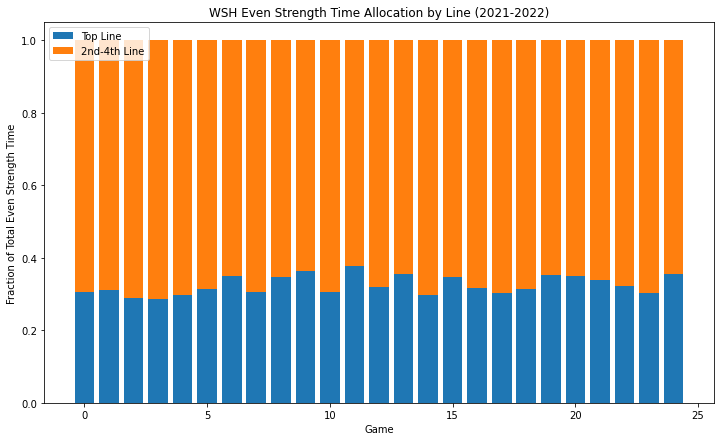

Average Fraction of Even Strength Time by Top Line (regular season):  0.3252289925113271


In [529]:
# Washington Capitals
WSH_home_df = home_results_df[home_results_df['team'] == 'WSH']
WSH_away_df = away_results_df[away_results_df['team'] == 'WSH']
WSH_df22 = pd.concat([WSH_home_df, WSH_away_df], axis=0).sort_index()
num_games = len(WSH_df22)
labels = [i for i in range(num_games)]
topline_fraction = WSH_df22['top line fraction']
remainder_fraction = WSH_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('WSH Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('WSH')
reg_season_avg_list.append(reg_season_avg)

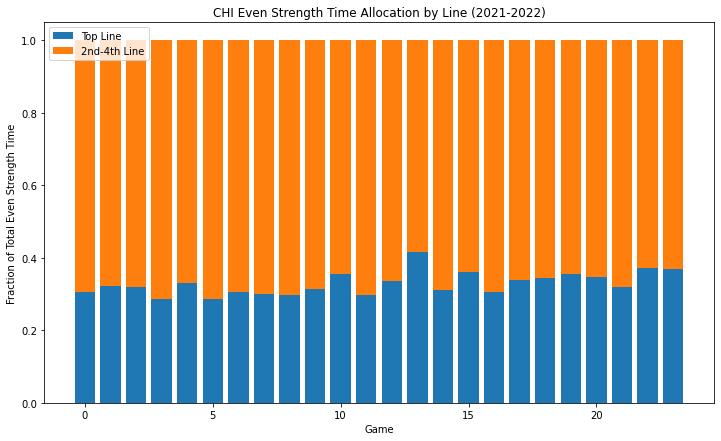

Average Fraction of Even Strength Time by Top Line (regular season):  0.3295316537982846


In [530]:
# Chicago Blackhawks
CHI_home_df = home_results_df[home_results_df['team'] == 'CHI']
CHI_away_df = away_results_df[away_results_df['team'] == 'CHI']
CHI_df22 = pd.concat([CHI_home_df, CHI_away_df], axis=0).sort_index()
num_games = len(CHI_df22)
labels = [i for i in range(num_games)]
topline_fraction = CHI_df22['top line fraction']
remainder_fraction = CHI_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('CHI Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CHI')
reg_season_avg_list.append(reg_season_avg)

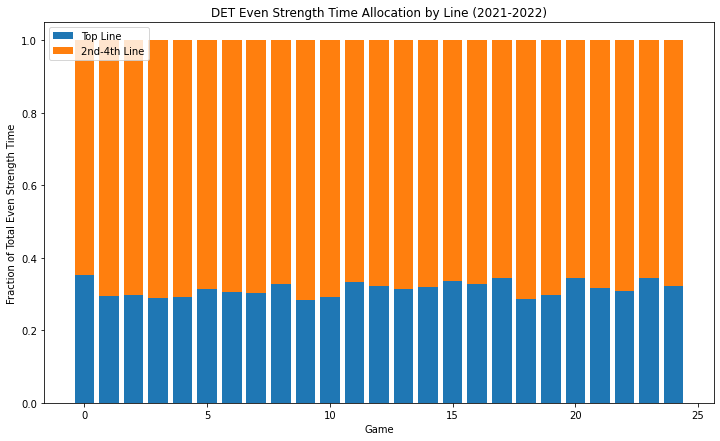

Average Fraction of Even Strength Time by Top Line (regular season):  0.31469704693647044


In [531]:
# Detroit Red Wings
DET_home_df = home_results_df[home_results_df['team'] == 'DET']
DET_away_df = away_results_df[away_results_df['team'] == 'DET']
DET_df22 = pd.concat([DET_home_df, DET_away_df], axis=0).sort_index()
num_games = len(DET_df22)
labels = [i for i in range(num_games)]
topline_fraction = DET_df22['top line fraction']
remainder_fraction = DET_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('DET Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('DET')
reg_season_avg_list.append(reg_season_avg)

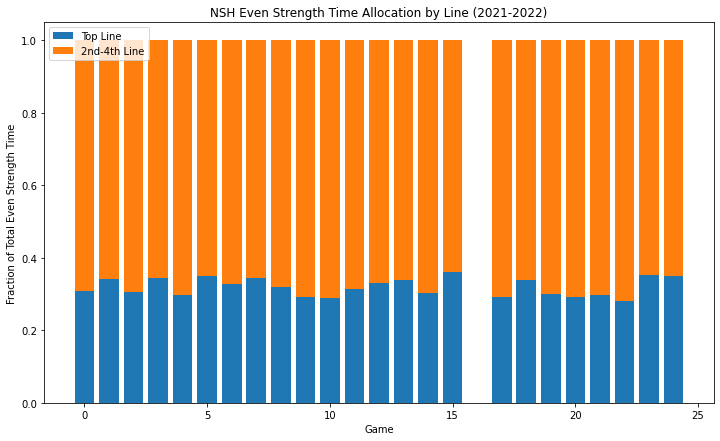

Average Fraction of Even Strength Time by Top Line (regular season):  0.31984883430305805


In [532]:
# Nashville Predators
NSH_home_df = home_results_df[home_results_df['team'] == 'NSH']
NSH_away_df = away_results_df[away_results_df['team'] == 'NSH']
NSH_df22 = pd.concat([NSH_home_df, NSH_away_df], axis=0).sort_index()
num_games = len(NSH_df22) # NSH had 1 game canceled
labels = [i for i in range(num_games)]
topline_fraction = NSH_df22['top line fraction']
remainder_fraction = NSH_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('NSH Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/(num_games-1))
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('NSH')
reg_season_avg_list.append(reg_season_avg)

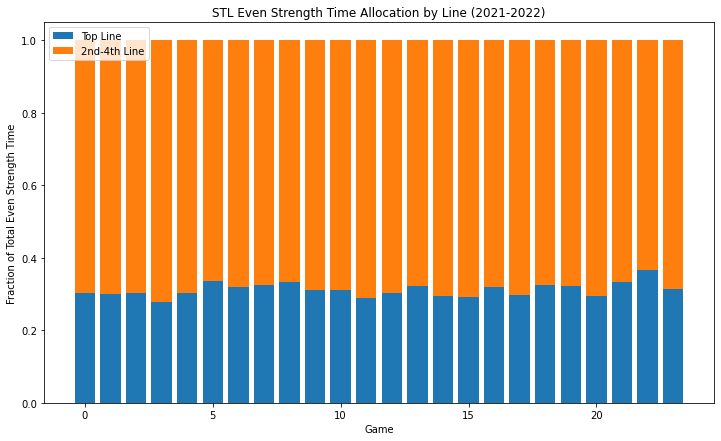

Average Fraction of Even Strength Time by Top Line (regular season):  0.3123084149675785


In [533]:
# St. Louis Blues
STL_home_df = home_results_df[home_results_df['team'] == 'STL']
STL_away_df = away_results_df[away_results_df['team'] == 'STL']
STL_df22 = pd.concat([STL_home_df, STL_away_df], axis=0).sort_index()
num_games = len(STL_df22)
labels = [i for i in range(num_games)]
topline_fraction = STL_df22['top line fraction']
remainder_fraction = STL_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('STL Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('STL')
reg_season_avg_list.append(reg_season_avg)

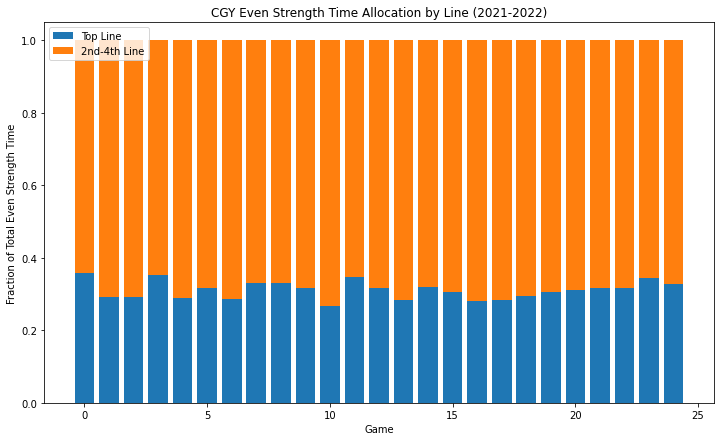

Average Fraction of Even Strength Time by Top Line (regular season):  0.3112509715184651


In [534]:
# Calgary Flames
CGY_home_df = home_results_df[home_results_df['team'] == 'CGY']
CGY_away_df = away_results_df[away_results_df['team'] == 'CGY']
CGY_df22 = pd.concat([CGY_home_df, CGY_away_df], axis=0).sort_index()
num_games = len(CGY_df22)
labels = [i for i in range(num_games)]
topline_fraction = CGY_df22['top line fraction']
remainder_fraction = CGY_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('CGY Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CGY')
reg_season_avg_list.append(reg_season_avg)

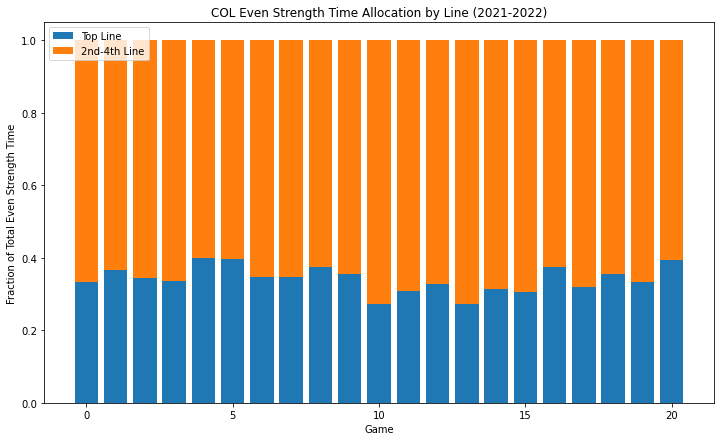

Average Fraction of Even Strength Time by Top Line (regular season):  0.34183134743609733


In [535]:
# Colorado Avalanche
COL_home_df = home_results_df[home_results_df['team'] == 'COL']
COL_away_df = away_results_df[away_results_df['team'] == 'COL']
COL_df22 = pd.concat([COL_home_df, COL_away_df], axis=0).sort_index()
num_games = len(COL_df22)
labels = [i for i in range(num_games)]
topline_fraction = COL_df22['top line fraction']
remainder_fraction = COL_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('COL Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('COL')
reg_season_avg_list.append(reg_season_avg)

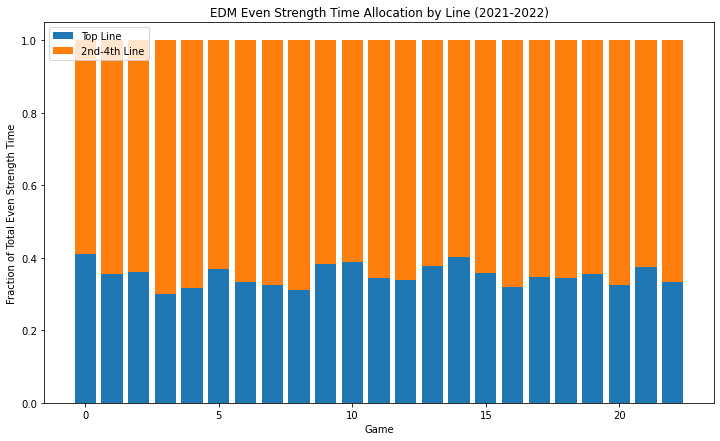

Average Fraction of Even Strength Time by Top Line (regular season):  0.35085182490534517


In [536]:
# Edmonton Oilers
EDM_home_df = home_results_df[home_results_df['team'] == 'EDM']
EDM_away_df = away_results_df[away_results_df['team'] == 'EDM']
EDM_df22 = pd.concat([EDM_home_df, EDM_away_df], axis=0).sort_index()
num_games = len(EDM_df22)
labels = [i for i in range(num_games)]
topline_fraction = EDM_df22['top line fraction']
remainder_fraction = EDM_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('EDM Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('EDM')
reg_season_avg_list.append(reg_season_avg)

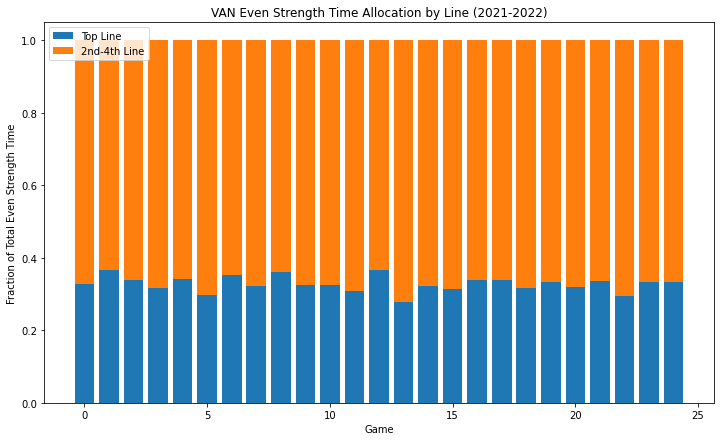

Average Fraction of Even Strength Time by Top Line (regular season):  0.32863657082818


In [537]:
# Vancouver Canucks
VAN_home_df = home_results_df[home_results_df['team'] == 'VAN']
VAN_away_df = away_results_df[away_results_df['team'] == 'VAN']
VAN_df22 = pd.concat([VAN_home_df, VAN_away_df], axis=0).sort_index()
num_games = len(VAN_df22)
labels = [i for i in range(num_games)]
topline_fraction = VAN_df22['top line fraction']
remainder_fraction = VAN_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('VAN Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('VAN')
reg_season_avg_list.append(reg_season_avg)

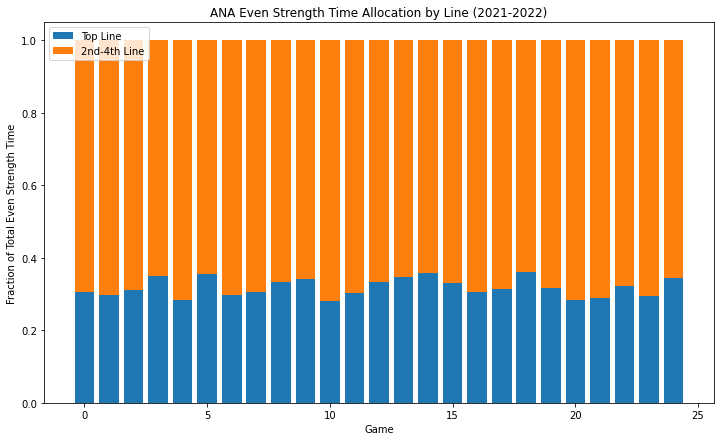

Average Fraction of Even Strength Time by Top Line (regular season):  0.31884970152272507


In [538]:
# Anaheim Ducks
ANA_home_df = home_results_df[home_results_df['team'] == 'ANA']
ANA_away_df = away_results_df[away_results_df['team'] == 'ANA']
ANA_df22 = pd.concat([ANA_home_df, ANA_away_df], axis=0).sort_index()
num_games = len(ANA_df22)
labels = [i for i in range(num_games)]
topline_fraction = ANA_df22['top line fraction']
remainder_fraction = ANA_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('ANA Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('ANA')
reg_season_avg_list.append(reg_season_avg)

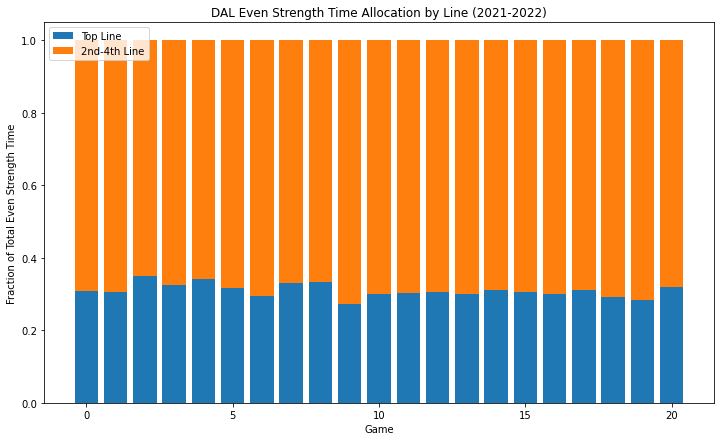

Average Fraction of Even Strength Time by Top Line (regular season):  0.3101669959313347


In [539]:
# Dallas Stars
DAL_home_df = home_results_df[home_results_df['team'] == 'DAL']
DAL_away_df = away_results_df[away_results_df['team'] == 'DAL']
DAL_df22 = pd.concat([DAL_home_df, DAL_away_df], axis=0).sort_index()
num_games = len(DAL_df22)
labels = [i for i in range(num_games)]
topline_fraction = DAL_df22['top line fraction']
remainder_fraction = DAL_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('DAL Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('DAL')
reg_season_avg_list.append(reg_season_avg)

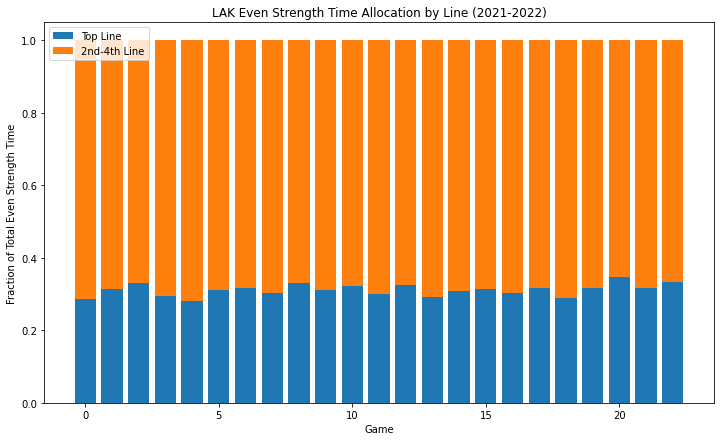

Average Fraction of Even Strength Time by Top Line (regular season):  0.31162617384407265


In [540]:
# Los Angeles Kings
LAK_home_df = home_results_df[home_results_df['team'] == 'LAK']
LAK_away_df = away_results_df[away_results_df['team'] == 'LAK']
LAK_df22 = pd.concat([LAK_home_df, LAK_away_df], axis=0).sort_index()
num_games = len(LAK_df22)
labels = [i for i in range(num_games)]
topline_fraction = LAK_df22['top line fraction']
remainder_fraction = LAK_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('LAK Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('LAK')
reg_season_avg_list.append(reg_season_avg)

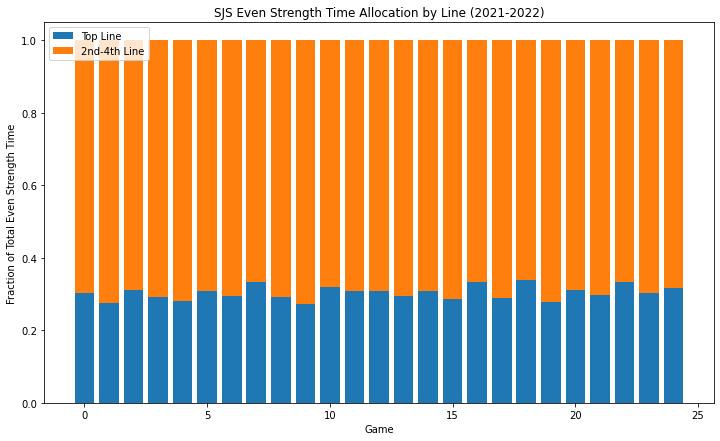

Average Fraction of Even Strength Time by Top Line (regular season):  0.3037762190421604


In [541]:
# San Jose Sharks
SJS_home_df = home_results_df[home_results_df['team'] == 'SJS']
SJS_away_df = away_results_df[away_results_df['team'] == 'SJS']
SJS_df22 = pd.concat([SJS_home_df, SJS_away_df], axis=0).sort_index()
num_games = len(SJS_df22)
labels = [i for i in range(num_games)]
topline_fraction = SJS_df22['top line fraction']
remainder_fraction = SJS_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('SJS Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('SJS')
reg_season_avg_list.append(reg_season_avg)

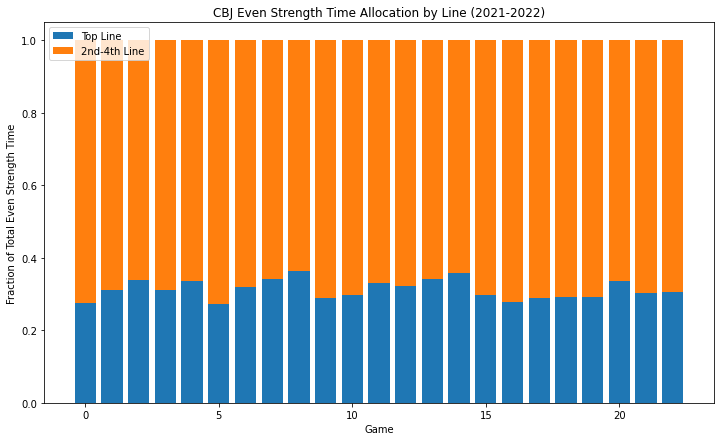

Average Fraction of Even Strength Time by Top Line (regular season):  0.31339238433820193


In [542]:
# Columbus Blue Jackets
CBJ_home_df = home_results_df[home_results_df['team'] == 'CBJ']
CBJ_away_df = away_results_df[away_results_df['team'] == 'CBJ']
CBJ_df22 = pd.concat([CBJ_home_df, CBJ_away_df], axis=0).sort_index()
num_games = len(CBJ_df22)
labels = [i for i in range(num_games)]
topline_fraction = CBJ_df22['top line fraction']
remainder_fraction = CBJ_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('CBJ Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('CBJ')
reg_season_avg_list.append(reg_season_avg)

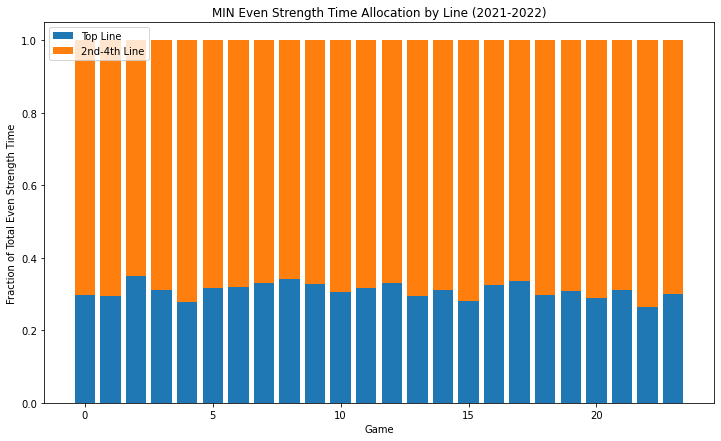

Average Fraction of Even Strength Time by Top Line (regular season):  0.309872117917846


In [543]:
# Minnesota Wild
MIN_home_df = home_results_df[home_results_df['team'] == 'MIN']
MIN_away_df = away_results_df[away_results_df['team'] == 'MIN']
MIN_df22 = pd.concat([MIN_home_df, MIN_away_df], axis=0).sort_index()
num_games = len(MIN_df22)
labels = [i for i in range(num_games)]
topline_fraction = MIN_df22['top line fraction']
remainder_fraction = MIN_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('MIN Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('MIN')
reg_season_avg_list.append(reg_season_avg)

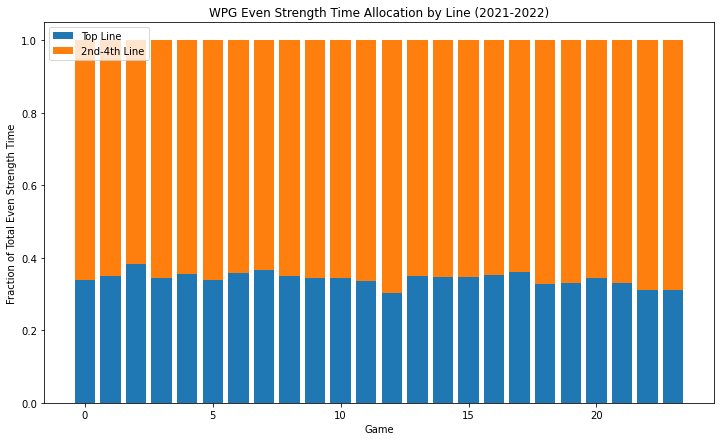

Average Fraction of Even Strength Time by Top Line (regular season):  0.34271643448743117


In [544]:
# Winnipeg Jets
WPG_home_df = home_results_df[home_results_df['team'] == 'WPG']
WPG_away_df = away_results_df[away_results_df['team'] == 'WPG']
WPG_df22 = pd.concat([WPG_home_df, WPG_away_df], axis=0).sort_index()
num_games = len(WPG_df22)
labels = [i for i in range(num_games)]
topline_fraction = WPG_df22['top line fraction']
remainder_fraction = WPG_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('WPG Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('WPG')
reg_season_avg_list.append(reg_season_avg)

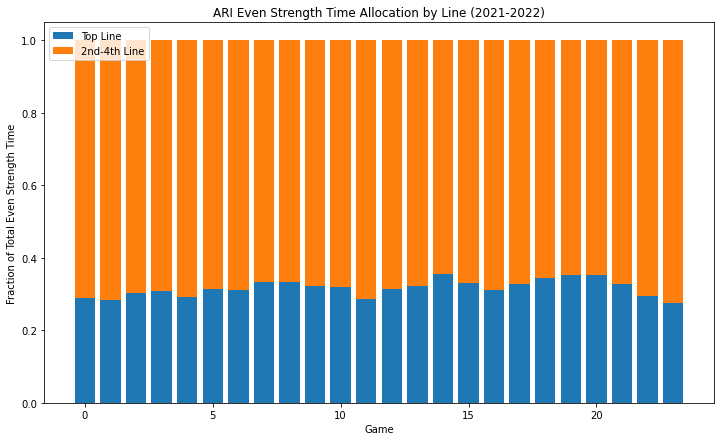

Average Fraction of Even Strength Time by Top Line (regular season):  0.3166656711441367


In [545]:
# Arizona Coyotes
ARI_home_df = home_results_df[home_results_df['team'] == 'ARI']
ARI_away_df = away_results_df[away_results_df['team'] == 'ARI']
ARI_df22 = pd.concat([ARI_home_df, ARI_away_df], axis=0).sort_index()
num_games = len(ARI_df22)
labels = [i for i in range(num_games)]
topline_fraction = ARI_df22['top line fraction']
remainder_fraction = ARI_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('ARI Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('ARI')
reg_season_avg_list.append(reg_season_avg)

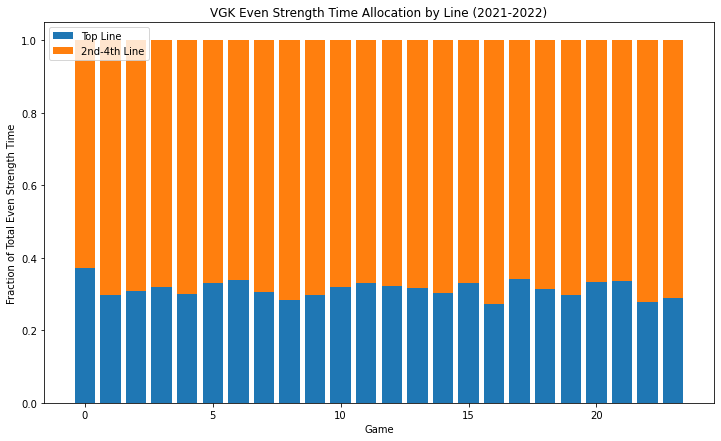

Average Fraction of Even Strength Time by Top Line (regular season):  0.314001206085337


In [546]:
# Vegas Golden Knights
VGK_home_df = home_results_df[home_results_df['team'] == 'VGK']
VGK_away_df = away_results_df[away_results_df['team'] == 'VGK']
VGK_df22 = pd.concat([VGK_home_df, VGK_away_df], axis=0).sort_index()
num_games = len(VGK_df22)
labels = [i for i in range(num_games)]
topline_fraction = VGK_df22['top line fraction']
remainder_fraction = VGK_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('VGK Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('VGK')
reg_season_avg_list.append(reg_season_avg)

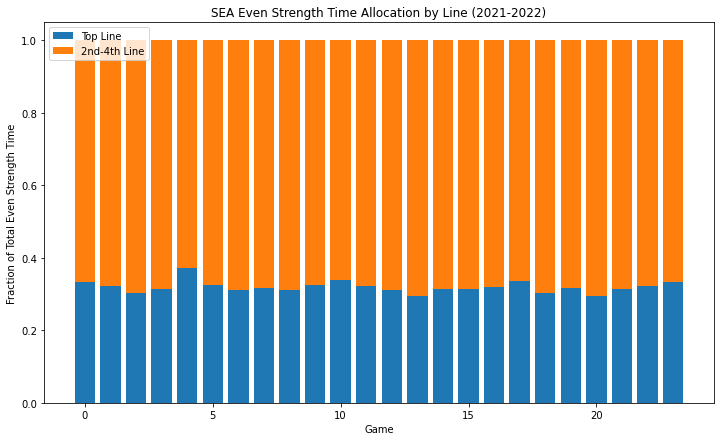

Average Fraction of Even Strength Time by Top Line (regular season):  0.31954958629730185


In [547]:
# Seattle Kraken
SEA_home_df = home_results_df[home_results_df['team'] == 'SEA']
SEA_away_df = away_results_df[away_results_df['team'] == 'SEA']
SEA_df22 = pd.concat([SEA_home_df, SEA_away_df], axis=0).sort_index()
num_games = len(SEA_df22)
labels = [i for i in range(num_games)]
topline_fraction = SEA_df22['top line fraction']
remainder_fraction = SEA_df22['2-4 lines fraction']
fig, ax = plt.subplots()
ax.bar(labels, topline_fraction, label='Top Line')
ax.bar(labels, remainder_fraction, bottom=topline_fraction, label='2nd-4th Line')
ax.set_ylabel('Fraction of Total Even Strength Time')
ax.set_xlabel('Game')
ax.set_title('SEA Even Strength Time Allocation by Line (2021-2022)')
ax.legend(loc='upper left')
plt.show()
reg_season_avg = sum(topline_fraction/num_games)
print('Average Fraction of Even Strength Time by Top Line (regular season): ', 
      reg_season_avg)
team_abbrev_list.append('SEA')
reg_season_avg_list.append(reg_season_avg)

In [548]:
summary_20212022_df = pd.DataFrame({
    'team': team_abbrev_list,
    'regular season average': reg_season_avg_list
})

In [549]:
pd.options.display.float_format = '{:,.5f}'.format
summary_20212022_df

,team,regular season average
0,NJD,0.30941
1,NYI,0.30884
2,NYR,0.31246
3,PHI,0.30415
4,PIT,0.31406
5,BOS,0.30516
6,BUF,0.29836
7,MTL,0.31425
8,OTT,0.32750
9,TOR,0.32200


In [550]:
# formatting for better readability
pd.options.display.float_format = '{:,.3f}%'.format
formatted_20212022 = summary_20212022_df
formatted_20212022['regular season average'] = formatted_20212022['regular season average'].apply(lambda x: x*100)

In [551]:
formatted_20212022.sort_values(by='regular season average', ascending=False)

,team,regular season average
20,EDM,35.085%
28,WPG,34.272%
19,COL,34.183%
14,CHI,32.953%
21,VAN,32.864%
8,OTT,32.750%
13,WSH,32.523%
12,TBL,32.342%
9,TOR,32.200%
16,NSH,31.985%


## Compare across seasons

In [591]:
combined_team_abbrev_list = []
combined_reg_season_avg_list = []

In [592]:
# calculate average regular season usage across both seasons for each team
# NJD
num_games = len(NJD_df) + len(NJD_df22)
topline_fraction21 = NJD_df['top line fraction']
topline_fraction22 = NJD_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('NJD')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# NYI
num_games = len(NYI_df) + len(NYI_df22)
topline_fraction21 = NYI_df['top line fraction']
topline_fraction22 = NYI_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('NYI')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# NYR
num_games = len(NYR_df) + len(NYR_df22)
topline_fraction21 = NYR_df['top line fraction']
topline_fraction22 = NYR_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('NYR')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# PHI
num_games = len(PHI_df) + len(PHI_df22)
topline_fraction21 = PHI_df['top line fraction']
topline_fraction22 = PHI_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('PHI')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# PIT
num_games = len(PIT_df) + len(PIT_df22)
topline_fraction21 = PIT_df['top line fraction']
topline_fraction22 = PIT_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('PIT')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# BOS
num_games = len(BOS_df) + len(BOS_df22)
topline_fraction21 = BOS_df['top line fraction']
topline_fraction22 = BOS_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('BOS')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# BUF
num_games = len(BUF_df) + len(BUF_df22)
topline_fraction21 = BUF_df['top line fraction']
topline_fraction22 = BUF_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('BUF')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# MTL
num_games = len(MTL_df) + len(MTL_df22)
topline_fraction21 = MTL_df['top line fraction']
topline_fraction22 = MTL_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('MTL')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# OTT
num_games = len(OTT_df) + len(OTT_df22)
topline_fraction21 = OTT_df['top line fraction']
topline_fraction22 = OTT_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('OTT')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# TOR
num_games = len(TOR_df) + len(TOR_df22)
topline_fraction21 = TOR_df['top line fraction']
topline_fraction22 = TOR_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('TOR')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# CAR
num_games = len(CAR_df) + len(CAR_df22)
topline_fraction21 = CAR_df['top line fraction']
topline_fraction22 = CAR_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('CAR')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# FLA
num_games = len(FLA_df) + len(FLA_df22)
topline_fraction21 = FLA_df['top line fraction']
topline_fraction22 = FLA_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('FLA')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# TBL
num_games = len(TBL_df) + len(TBL_df22)
topline_fraction21 = TBL_df['top line fraction']
topline_fraction22 = TBL_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('TBL')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# WSH
num_games = len(WSH_df) + len(WSH_df22)
topline_fraction21 = WSH_df['top line fraction']
topline_fraction22 = WSH_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('WSH')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# CHI
num_games = len(CHI_df) + len(CHI_df22)
topline_fraction21 = CHI_df['top line fraction']
topline_fraction22 = CHI_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('CHI')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# DET
num_games = len(DET_df) + len(DET_df22)
topline_fraction21 = DET_df['top line fraction']
topline_fraction22 = DET_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('DET')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# NSH
num_games = len(NSH_df) + len(NSH_df22)
topline_fraction21 = NSH_df['top line fraction']
topline_fraction22 = NSH_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('NSH')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# STL
num_games = len(STL_df) + len(STL_df22)
topline_fraction21 = STL_df['top line fraction']
topline_fraction22 = STL_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('STL')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# CGY
num_games = len(CGY_df) + len(CGY_df22)
topline_fraction21 = CGY_df['top line fraction']
topline_fraction22 = CGY_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('CGY')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# COL
num_games = len(COL_df) + len(COL_df22)
topline_fraction21 = COL_df['top line fraction']
topline_fraction22 = COL_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('COL')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# EDM
num_games = len(EDM_df) + len(EDM_df22)
topline_fraction21 = EDM_df['top line fraction']
topline_fraction22 = EDM_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('EDM')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# VAN
num_games = len(VAN_df) + len(VAN_df22)
topline_fraction21 = VAN_df['top line fraction']
topline_fraction22 = VAN_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('VAN')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# ANA
num_games = len(ANA_df) + len(ANA_df22)
topline_fraction21 = ANA_df['top line fraction']
topline_fraction22 = ANA_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('ANA')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# DAL
num_games = len(DAL_df) + len(DAL_df22)
topline_fraction21 = DAL_df['top line fraction']
topline_fraction22 = DAL_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('DAL')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# LAK
num_games = len(LAK_df) + len(LAK_df22)
topline_fraction21 = LAK_df['top line fraction']
topline_fraction22 = LAK_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('LAK')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# SJS
num_games = len(SJS_df) + len(SJS_df22)
topline_fraction21 = SJS_df['top line fraction']
topline_fraction22 = SJS_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('SJS')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# CBJ
num_games = len(CBJ_df) + len(CBJ_df22)
topline_fraction21 = CBJ_df['top line fraction']
topline_fraction22 = CBJ_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('CBJ')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# MIN
num_games = len(MIN_df) + len(MIN_df22)
topline_fraction21 = MIN_df['top line fraction']
topline_fraction22 = MIN_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('MIN')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# WPG
num_games = len(WPG_df) + len(WPG_df22)
topline_fraction21 = WPG_df['top line fraction']
topline_fraction22 = WPG_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('WPG')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# ARI
num_games = len(ARI_df) + len(ARI_df22)
topline_fraction21 = ARI_df['top line fraction']
topline_fraction22 = ARI_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('ARI')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# VGK
num_games = len(VGK_df) + len(VGK_df22)
topline_fraction21 = VGK_df['top line fraction']
topline_fraction22 = VGK_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction21) + sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('VGK')
combined_reg_season_avg_list.append(combined_reg_season_avg)

# SEA
num_games = len(SEA_df22)
topline_fraction22 = SEA_df22['top line fraction']
combined_reg_season_avg = (sum(topline_fraction22)) / num_games
combined_team_abbrev_list.append('SEA')
combined_reg_season_avg_list.append(combined_reg_season_avg)

In [593]:
combined_regseason_summary_df = pd.DataFrame({
    'team': combined_team_abbrev_list,
    'combined regular season average': combined_reg_season_avg_list
})

combined_regseason_summary_df['combined regular season average'] = combined_regseason_summary_df['combined regular season average']*100

In [594]:
summary_combined = pd.concat([formatted_20202021, formatted_20212022, combined_regseason_summary_df]
                             , axis=1) # easier than joining due to SEA missing in 20-21

In [595]:
# reformat dataframe
summary_combined = summary_combined.set_axis(['drop', '20-21 reg. season avg.', '20-21 playoff avg.',
                                              '20-21 combined avg.', 'drop', '21-22 reg. season avg.',
                                             'team', 'combined reg. season avg.'], axis=1)
summary_combined = summary_combined.drop(columns=['drop'])
summary_combined = summary_combined[['team', '20-21 reg. season avg.', '20-21 playoff avg.',
                                     '20-21 combined avg.', '21-22 reg. season avg.',
                                     'combined reg. season avg.']]

In [597]:
summary_combined.sort_values(by='combined reg. season avg.', ascending=False)

,team,20-21 reg. season avg.,20-21 playoff avg.,20-21 combined avg.,21-22 reg. season avg.,combined reg. season avg.
20,EDM,34.255%,38.429%,34.533%,35.085%,34.686%
28,WPG,33.022%,35.896%,33.381%,34.272%,33.624%
19,COL,33.005%,34.461%,33.226%,34.183%,33.457%
9,TOR,33.627%,35.441%,33.828%,32.200%,33.353%
14,CHI,33.295%,N/A,N/A,32.953%,33.193%
4,PIT,33.386%,31.281%,33.182%,31.406%,32.687%
21,VAN,32.257%,N/A,N/A,32.864%,32.444%
31,SEA,NaN,NaN,NaN,31.955%,31.955%
15,DET,32.143%,N/A,N/A,31.470%,31.935%
13,WSH,31.649%,31.162%,31.609%,32.523%,31.875%


In [599]:
# calculate change between regular seasons for each team
summary_combined['20-21 to 21-22 reg. season change'] = (summary_combined['21-22 reg. season avg.'] - 
                                                         summary_combined['20-21 reg. season avg.'])
summary_combined.sort_values(by='20-21 to 21-22 reg. season change', ascending=False)

,team,20-21 reg. season avg.,20-21 playoff avg.,20-21 combined avg.,21-22 reg. season avg.,combined reg. season avg.,20-21 to 21-22 reg. season change
8,OTT,30.501%,N/A,N/A,32.750%,30.386%,2.249%
16,NSH,30.447%,28.765%,30.284%,31.985%,30.405%,1.538%
12,TBL,30.860%,31.730%,31.113%,32.342%,31.399%,1.482%
22,ANA,30.501%,N/A,N/A,31.885%,30.928%,1.384%
28,WPG,33.022%,35.896%,33.381%,34.272%,33.624%,1.250%
19,COL,33.005%,34.461%,33.226%,34.183%,33.457%,1.178%
7,MTL,30.399%,30.500%,30.427%,31.425%,30.677%,1.027%
29,ARI,30.729%,N/A,N/A,31.667%,31.010%,0.938%
13,WSH,31.649%,31.162%,31.609%,32.523%,31.875%,0.874%
20,EDM,34.255%,38.429%,34.533%,35.085%,34.686%,0.830%


In [600]:
summary_combined.sort_values(by='combined reg. season avg.', ascending=False)

,team,20-21 reg. season avg.,20-21 playoff avg.,20-21 combined avg.,21-22 reg. season avg.,combined reg. season avg.,20-21 to 21-22 reg. season change
20,EDM,34.255%,38.429%,34.533%,35.085%,34.686%,0.830%
28,WPG,33.022%,35.896%,33.381%,34.272%,33.624%,1.250%
19,COL,33.005%,34.461%,33.226%,34.183%,33.457%,1.178%
9,TOR,33.627%,35.441%,33.828%,32.200%,33.353%,-1.427%
14,CHI,33.295%,N/A,N/A,32.953%,33.193%,-0.342%
4,PIT,33.386%,31.281%,33.182%,31.406%,32.687%,-1.980%
21,VAN,32.257%,N/A,N/A,32.864%,32.444%,0.607%
31,SEA,NaN,NaN,NaN,31.955%,31.955%,NaN
15,DET,32.143%,N/A,N/A,31.470%,31.935%,-0.673%
13,WSH,31.649%,31.162%,31.609%,32.523%,31.875%,0.874%
